In [1]:
# IMPORT NECESSARY LIBRARIES
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn import datasets, metrics, model_selection, svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import soundfile as sf
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
seed=7
np.random.seed(seed)

In [2]:
# CREATE DIRECTORY OF AUDIO FILES 
audio = "/content/drive/MyDrive/Speech Emotion analysis/RAVDESS/audio_speech_actors_01-24/"
actor_folders = os.listdir(audio) #list files in audio directory
actor_folders.sort() 
actor_folders[0:24]

['Actor_01',
 'Actor_02',
 'Actor_03',
 'Actor_04',
 'Actor_05',
 'Actor_06',
 'Actor_07',
 'Actor_08',
 'Actor_09',
 'Actor_10',
 'Actor_11',
 'Actor_12',
 'Actor_13',
 'Actor_14',
 'Actor_15',
 'Actor_16',
 'Actor_17',
 'Actor_18',
 'Actor_19',
 'Actor_20',
 'Actor_21',
 'Actor_22',
 'Actor_23',
 'Actor_24']

In [3]:
# CREATE FUNCTION TO EXTRACT EMOTION NUMBER, ACTOR AND GENDER LABEL
emotion = []
gender = []
actor = []
file_path = []
for i in actor_folders:
    filename = os.listdir(audio + i) #iterate over Actor folders
    for f in filename: # go through files in Actor folder
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        actor.append(int(part[6]))
        bg = int(part[6])
        if bg%2 == 0:
            bg = "female"
        else:
            bg = "male"
        gender.append(bg)
        file_path.append(audio + i + '/' + f)

In [4]:
# PUT EXTRACTED LABELS WITH FILEPATH INTO DATAFRAME
audio_df = pd.DataFrame(emotion)
audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
audio_df = pd.concat([pd.DataFrame(gender),audio_df,pd.DataFrame(actor)],axis=1)
audio_df.columns = ['gender','emotion','actor']
audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)
audio_df

gender  ...                                               path
0       male  ...  /content/drive/MyDrive/Speech Emotion analysis...
1       male  ...  /content/drive/MyDrive/Speech Emotion analysis...
2       male  ...  /content/drive/MyDrive/Speech Emotion analysis...
3       male  ...  /content/drive/MyDrive/Speech Emotion analysis...
4       male  ...  /content/drive/MyDrive/Speech Emotion analysis...
...      ...  ...                                                ...
1435  female  ...  /content/drive/MyDrive/Speech Emotion analysis...
1436  female  ...  /content/drive/MyDrive/Speech Emotion analysis...
1437  female  ...  /content/drive/MyDrive/Speech Emotion analysis...
1438  female  ...  /content/drive/MyDrive/Speech Emotion analysis...
1439  female  ...  /content/drive/MyDrive/Speech Emotion analysis...

[1440 rows x 4 columns]

In [5]:
# ENSURE GENDER,EMOTION, AND ACTOR COLUMN VALUES ARE CORRECT
pd.set_option('display.max_colwidth', -1)

audio_df.sample(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


gender  ...                                                                                                                path
810  female  ...  /content/drive/MyDrive/Speech Emotion analysis/RAVDESS/audio_speech_actors_01-24/Actor_14/03-01-06-02-01-02-14.wav
489  male    ...  /content/drive/MyDrive/Speech Emotion analysis/RAVDESS/audio_speech_actors_01-24/Actor_09/03-01-01-01-01-02-09.wav
799  female  ...  /content/drive/MyDrive/Speech Emotion analysis/RAVDESS/audio_speech_actors_01-24/Actor_14/03-01-01-01-02-01-14.wav
680  female  ...  /content/drive/MyDrive/Speech Emotion analysis/RAVDESS/audio_speech_actors_01-24/Actor_12/03-01-03-02-01-01-12.wav
898  male    ...  /content/drive/MyDrive/Speech Emotion analysis/RAVDESS/audio_speech_actors_01-24/Actor_15/03-01-07-01-02-01-15.wav
656  male    ...  /content/drive/MyDrive/Speech Emotion analysis/RAVDESS/audio_speech_actors_01-24/Actor_11/03-01-02-02-02-01-11.wav
978  male    ...  /content/drive/MyDrive/Speech Emotion analysis/RAVDESS/audio_speech_actors_01-24/Actor_17/03-01-02-02-02-02-17.wav
816  female  ...  /content/drive/MyDrive/Speech Emotion analysis/RAVDESS/audio_speech_actors_01-24/Actor_14/03-01-05-02-01-02-14.wav
518  male    ...  /content/drive/MyDrive/Speech Emotion analysis/RAVDESS/audio_speech_actors_01-24/Actor_09/03-01-05-01-02-01-09.wav
228  female  ...  /content/drive/MyDrive/Speech Emotion analysis/RAVDESS/audio_speech_actors_01-24/Actor_04/03-01-08-01-01-02-04.wav

[10 rows x 4 columns]

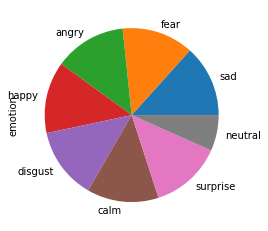

In [6]:
# LOOK AT DISTRIBUTION OF CLASSES
audio_df.emotion.value_counts().plot(kind='pie') 

In [7]:
# EXPORT TO CSV
audio_df.to_csv('/content/drive/MyDrive/Speech Emotion analysis/RAVDESS/audio.csv')

In [8]:
# Read Data
data = pd.read_csv('/content/drive/MyDrive/Speech Emotion analysis/RAVDESS/audio.csv')
data.head(5)
data.shape

(1440, 5)

In [ ]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT MFCC MEAN VALUES INTO DF FOR MODELING
import pandas as pd 
df = pd.DataFrame(columns=['mfcc'])

counter=0

for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    # Mel-frequency cepstral coefficients (MFCCs)
    mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
    mfcc=np.mean(mfcc,axis=0)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    #spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    #db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    #log_spectrogram = np.mean(db_spec, axis = 0)      
    
    # compute chroma energy (pertains to 12 different pitch classes)
#     chroma = librosa.feature.chroma_stft(y=X, sr=sample_rate)
#     chroma = np.mean(chroma, axis = 0)

    # compute spectral contrast
#     contrast = librosa.feature.spectral_contrast(y=X, sr=sample_rate)
#     contrast = np.mean(contrast, axis= 0)

    # compute zero-crossing-rate (zcr:the zcr is the rate of sign changes along a signal i.e.m the rate at 
#     which the signal changes from positive to negative or back - separation of voiced andunvoiced speech.)
#     zcr = librosa.feature.zero_crossing_rate(y=X)
#     zcr = np.mean(zcr, axis= 0)
    
    df.loc[counter] = [mfcc]
    counter=counter+1   

print(len(df))
df.head()

1440


mfcc
0  [-65.80097, -65.80097, -65.80097, -65.80097, -65.80097, -65.80097, -65.80097, -65.80097, -65.80097, -65.80097, -65.80097, -65.80097, -65.80097, -65.80097, -65.80097, -65.80097, -65.79317, -65.80097, -65.80097, -65.80097, -63.896137, -60.06334, -61.391453, -59.506573, -61.304344, -60.47944, -59.622013, -59.31296, -56.807724, -57.467476, -54.780277, -54.33812, -56.67149, -56.021694, -55.159336, -55.876816, -56.127678, -56.435852, -55.660587, -53.22207, -52.017757, -51.894783, -48.247776, -36.872196, -34.63617, -35.332005, -35.97329, -29.694712, -25.790712, -25.337917, -26.04528, -26.533817, -25.579006, -23.874899, -24.262552, -26.132225, -27.260983, -27.198997, -27.877888, -28.448301, -27.748417, -26.44417, -25.269634, -24.475765, -24.007607, -24.083933, -24.724846, -26.4546, -29.186512, -31.163918, -30.411167, -29.63747, -31.555855, -31.773363, -34.2731, -34.29119, -30.010237, -27.754906, -26.995674, -28.3454, -29.476929, -28.65847, -28.281578, -27.731453, -26.625526, -25.776878, -27.227072, -30.215084, -32.357243, -33.921707, -34.512356, -38.663723, -31.177103, -27.843431, -27.614267, -27.758303, -25.314016, -24.831871, -26.060616, -24.967323, ...]       
1  [-70.26777, -70.26777, -70.26777, -70.26777, -70.26777, -70.26777, -70.26777, -70.26777, -70.26777, -70.26777, -70.26777, -70.26777, -70.00066, -69.98083, -70.26777, -70.26777, -70.26777, -70.26777, -70.26777, -70.26777, -66.09639, -63.39728, -68.259895, -70.26777, -69.665245, -68.81713, -66.11466, -63.901035, -68.62062, -70.26777, -69.64199, -68.42016, -70.04418, -67.23247, -66.35039, -68.50346, -66.57759, -62.98096, -62.69349, -65.90668, -67.47967, -65.50775, -60.183018, -46.305138, -42.03026, -41.176853, -40.39396, -42.781784, -41.630405, -42.38596, -35.06297, -29.963024, -27.710716, -28.12929, -29.228241, -28.922142, -29.863792, -29.137327, -27.562275, -26.559965, -27.29548, -25.76872, -26.59623, -26.585436, -27.215006, -27.260408, -29.628487, -28.612774, -29.271511, -29.694263, -30.584787, -31.252563, -31.215956, -31.923744, -32.84927, -32.42957, -28.261763, -26.577507, -28.145658, -28.639492, -29.120243, -30.14143, -31.6785, -33.357437, -36.92599, -37.68963, -38.747364, -39.802963, -36.427456, -34.17576, -33.679245, -35.412712, -35.74091, -37.221058, -38.811974, -37.915447, -36.90479, -36.520035, -31.522871, -29.419628, ...]                         
2  [-69.67329, -69.693306, -69.693306, -69.693306, -69.693306, -69.693306, -69.693306, -69.62077, -69.693306, -68.90657, -67.25143, -69.33355, -69.693306, -69.693306, -69.64757, -69.679306, -69.693306, -69.58893, -69.181244, -66.81849, -65.78479, -69.06355, -69.693306, -64.03848, -58.784462, -59.41652, -66.427635, -69.693306, -67.02764, -62.696476, -58.7794, -59.776413, -59.815422, -63.297573, -63.207493, -60.560482, -60.138103, -59.228004, -55.83927, -55.880684, -55.55764, -54.28214, -45.284294, -33.580116, -27.007612, -23.8461, -23.520456, -23.534494, -24.046532, -23.93682, -23.998068, -23.084843, -24.058361, -24.131268, -24.922611, -24.127537, -24.819418, -24.67441, -24.9374, -26.121553, -25.321491, -25.693386, -26.929605, -28.770864, -29.116423, -29.764034, -29.929077, -31.487223, -30.5484, -31.0623, -30.9809, -32.36285, -31.64961, -33.197414, -32.953857, -32.70321, -34.101414, -36.73828, -34.659702, -29.57563, -25.832706, -25.116682, -25.818705, -23.860353, -23.747295, -23.945332, -25.148958, -24.836567, -26.031755, -27.392134, -28.862919, -29.91248, -31.504059, -32.32983, -32.843163, -33.3809, -35.17451, -34.72634, -32.610207, -27.00693, ...]          
3  [-61.84994, -62.89504, -63.830635, -60.552586, -60.82168, -62.0734, -64.88923, -65.389946, -65.389946, -65.389946, -65.389946, -65.389946, -63.679653, -59.562466, -59.068306, -62.143024, -62.43146, -64.84182, -65.389946, -65.389946, -63.86984, -61.360493, -59.707012, -59.79804, -62.271156, -60.549892, -58.221012, -58.358536, -60.64837, -53.25378, -51.222225, -49.67905, -51.87568, -56.024105, -57.659172, -58.432064, -58.607403, -60.929775, -64.41891, -58.209

In [ ]:
# TURN ARRAY INTO LIST AND JOIN WITH AUDIO_DF TO GET CORRESPONDING EMOTION LABELS
df_combined = pd.concat([audio_df,pd.DataFrame(df['mfcc'].values.tolist())],axis=1)
df_combined = df_combined.fillna(0)
# DROP PATH COLUMN FOR MODELING
df_combined.drop(columns='path',inplace=True)
# CHECK TOP 5 ROWS
df_combined.head()
# TRAIN TEST SPLIT DATA
train,test = train_test_split(df_combined, test_size=0.20, random_state=0,
                               stratify=df_combined[['emotion','gender','actor']])
X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:2].drop(columns=['gender'])
print(X_train.shape)
X_test = test.iloc[:,3:]
y_test = test.iloc[:,:2].drop(columns=['gender'])
print(X_test.shape)
# Define the K-fold Cross Validator
kfold = KFold(n_splits=2, shuffle=True)
acc_per_fold = []
loss_per_fold = []
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(y_test[0:10])
# RESHAPE DATA TO INCLUDE 3D TENSOR 
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

print(X_train.shape)
print(X_test.shape)

inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)
inputs.shape
targets.shape

(1152, 259)
(288, 259)
[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]
(1152, 259, 1)
(288, 259, 1)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(1440, 8)

In [ ]:
# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
  model = tf.keras.Sequential()
  model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(X_train.shape[1],1)))
  model.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(8, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
  model.summary()
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  checkpoint = ModelCheckpoint("SER_best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
  model_history=model.fit(inputs[train], targets[train],batch_size=32, epochs=1000, validation_data=(X_test, y_test),callbacks=[checkpoint])
  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  # Increase fold number
  fold_no = fold_no + 1
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Streaming output truncated to the last 5000 lines.
Epoch 776/1000
34/34 [==============================] - 1s 25ms/step - loss: 0.3310 - accuracy: 0.9413 - val_loss: 0.6812 - val_accuracy: 0.9062

Epoch 00776: val_accuracy did not improve from 0.90972
Epoch 777/1000
34/34 [==============================] - 1s 26ms/step - loss: 0.2211 - accuracy: 0.9513 - val_loss: 0.7865 - val_accuracy: 0.8785

Epoch 00777: val_accuracy did not improve from 0.90972
Epoch 778/1000
34/34 [==============================] - 1s 26ms/step - loss: 0.2001 - accuracy: 0.9487 - val_loss: 0.8322 - val_accuracy: 0.8819

Epoch 00778: val_accuracy did not improve from 0.90972
Epoch 779/1000
34/34 [==============================] - 1s 26ms/step - loss: 0.1138 - accuracy: 0.9811 - val_loss: 0.9189 - val_accuracy: 0.8924

Epoch 00779: val_accuracy did not improve from 0.90972
Epoch 780/1000
34/34 [==============================] - 1s 25ms/step - loss: 0.1573 - accuracy: 0.9691 - val_loss: 0.8669 - val_accuracy: 0.8819


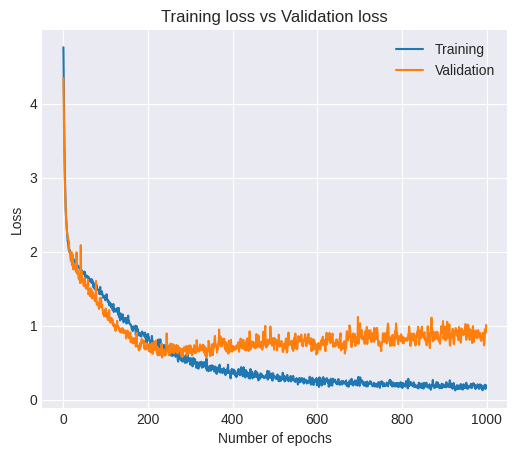

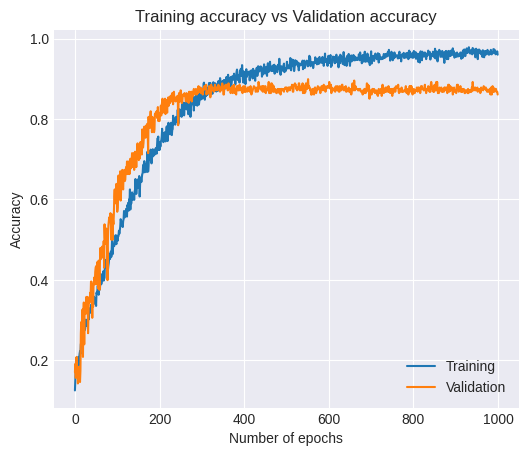

In [ ]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 100 
plt.figure(1,figsize=(6,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 100 
plt.figure(2,figsize=(6,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])      

9/9 [==============================] - 0s 10ms/step - loss: 1.0097 - accuracy: 0.8611
Loss of the model is -  1.0097005367279053
9/9 [==============================] - 0s 9ms/step - loss: 1.0097 - accuracy: 0.8611
Accuracy of the model is -  86.11111044883728 %


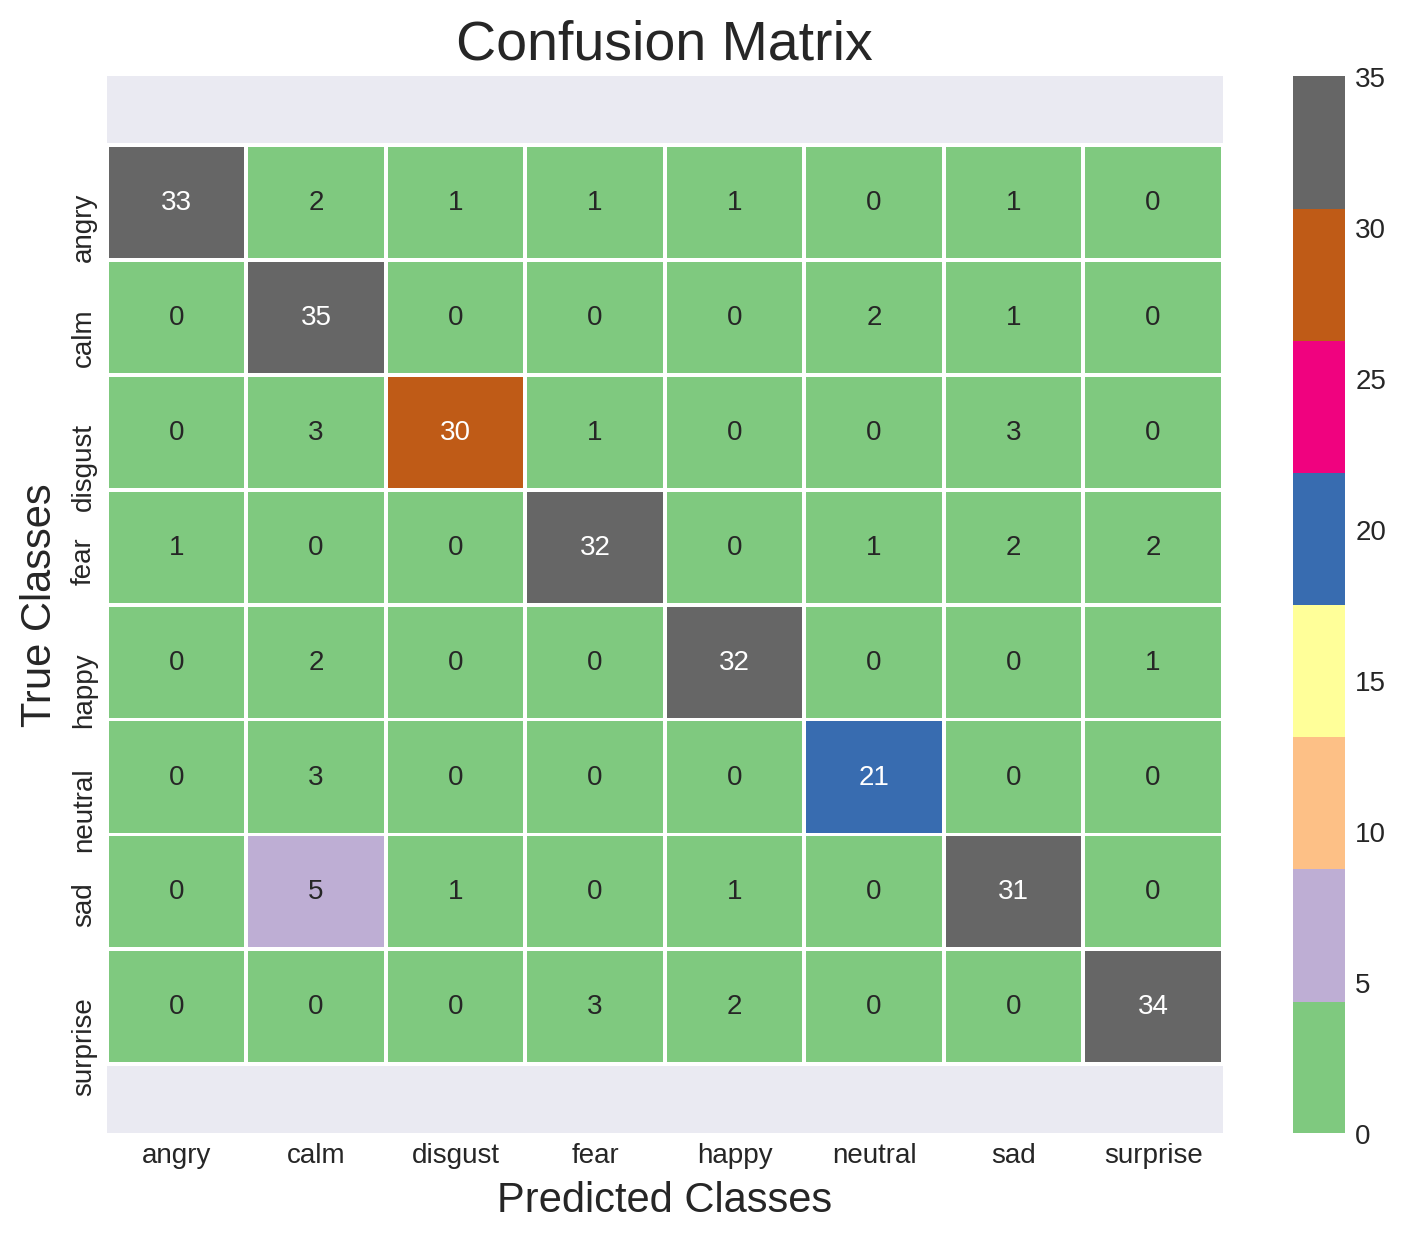

In [ ]:
# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[40:50] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 200 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('Initial_Model_Confusion_Matrix-SGD-CHROMA.png')
plt.show() 

In [ ]:
print(classification_report(TRUE, predictions, target_names = ['angry','calm','disgust','fear','happy','neutral','sad','surprise']))

              precision    recall  f1-score   support

       angry       0.97      0.85      0.90        39
        calm       0.70      0.92      0.80        38
     disgust       0.94      0.81      0.87        37
        fear       0.86      0.84      0.85        38
       happy       0.89      0.91      0.90        35
     neutral       0.88      0.88      0.88        24
         sad       0.82      0.82      0.82        38
    surprise       0.92      0.87      0.89        39

    accuracy                           0.86       288
   macro avg       0.87      0.86      0.86       288
weighted avg       0.87      0.86      0.86       288



In [ ]:
model = tf.keras.Sequential()
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(X_train.shape[1],1)))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
model_history=model.fit(inputs[train], targets[train],batch_size=32, epochs=1500, validation_data=(X_test, y_test),callbacks=[checkpoint])

Streaming output truncated to the last 5000 lines.
Epoch 251/1500
34/34 [==============================] - 1s 24ms/step - loss: 0.7035 - accuracy: 0.7977 - val_loss: 0.5732 - val_accuracy: 0.8611

Epoch 00251: val_accuracy did not improve from 0.88194
Epoch 252/1500
34/34 [==============================] - 1s 24ms/step - loss: 0.6338 - accuracy: 0.8221 - val_loss: 0.5627 - val_accuracy: 0.8750

Epoch 00252: val_accuracy did not improve from 0.88194
Epoch 253/1500
34/34 [==============================] - 1s 23ms/step - loss: 0.6051 - accuracy: 0.8206 - val_loss: 0.5918 - val_accuracy: 0.8681

Epoch 00253: val_accuracy did not improve from 0.88194
Epoch 254/1500
34/34 [==============================] - 1s 24ms/step - loss: 0.5824 - accuracy: 0.8389 - val_loss: 0.6499 - val_accuracy: 0.8646

Epoch 00254: val_accuracy did not improve from 0.88194
Epoch 255/1500
34/34 [==============================] - 1s 24ms/step - loss: 0.5606 - accuracy: 0.8314 - val_loss: 0.6200 - val_accuracy: 0.8611


9/9 [==============================] - 0s 10ms/step - loss: 0.9820 - accuracy: 0.8750
Loss of the model is -  0.9820161461830139
9/9 [==============================] - 0s 10ms/step - loss: 0.9820 - accuracy: 0.8750
Accuracy of the model is -  87.5 %


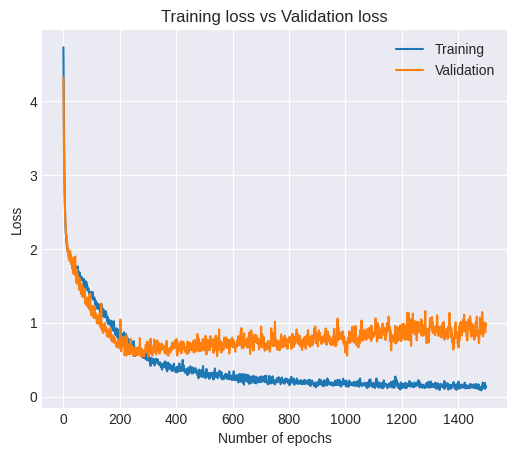

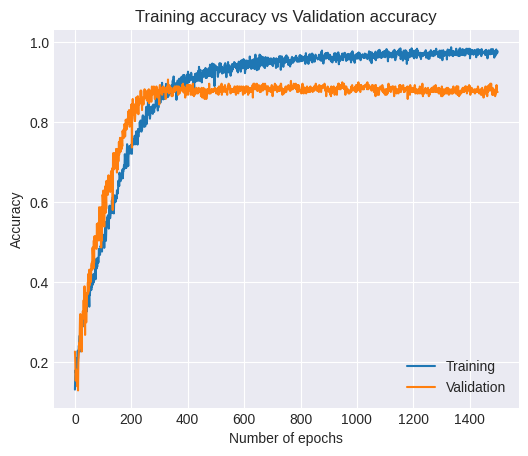

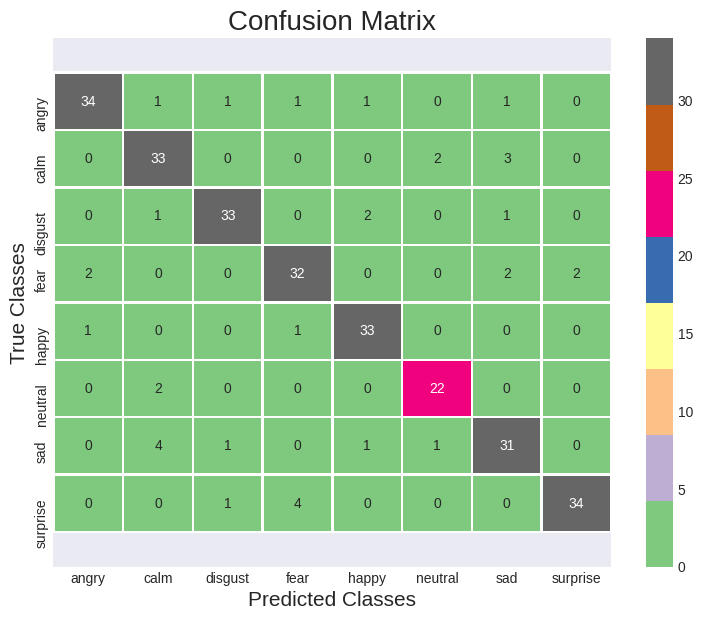

              precision    recall  f1-score   support

       angry       0.92      0.87      0.89        39
        calm       0.80      0.87      0.84        38
     disgust       0.92      0.89      0.90        37
        fear       0.84      0.84      0.84        38
       happy       0.89      0.94      0.92        35
     neutral       0.88      0.92      0.90        24
         sad       0.82      0.82      0.82        38
    surprise       0.94      0.87      0.91        39

    accuracy                           0.88       288
   macro avg       0.88      0.88      0.88       288
weighted avg       0.88      0.88      0.88       288



In [ ]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 100 
plt.figure(1,figsize=(6,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 100 
plt.figure(2,figsize=(6,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])      

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[40:50] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 150 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('Initial_Model_Confusion_Matrix-SGD-MFCC.png')
plt.show() 

print(classification_report(TRUE, predictions, target_names = ['angry','calm','disgust','fear','happy','neutral','sad','surprise'])) 

In [ ]:
# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
  model = tf.keras.Sequential()
  model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(X_train.shape[1],1)))
  model.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(8, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='Sgd',metrics=['accuracy'])
  model.summary()
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  checkpoint = ModelCheckpoint("SER_best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
  model_history=model.fit(inputs[train], targets[train],batch_size=32, epochs=1000, validation_data=(X_test, y_test),callbacks=[checkpoint])
  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  # Increase fold number
  fold_no = fold_no + 1
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Streaming output truncated to the last 5000 lines.
Epoch 775/1000
23/23 [==============================] - 1s 26ms/step - loss: 0.8438 - accuracy: 0.7200 - val_loss: 1.4058 - val_accuracy: 0.6146

Epoch 00775: val_accuracy did not improve from 0.66667
Epoch 776/1000
23/23 [==============================] - 1s 26ms/step - loss: 0.8063 - accuracy: 0.7193 - val_loss: 1.5591 - val_accuracy: 0.5833

Epoch 00776: val_accuracy did not improve from 0.66667
Epoch 777/1000
23/23 [==============================] - 1s 25ms/step - loss: 0.8640 - accuracy: 0.6843 - val_loss: 1.3953 - val_accuracy: 0.6493

Epoch 00777: val_accuracy did not improve from 0.66667
Epoch 778/1000
23/23 [==============================] - 1s 26ms/step - loss: 0.8187 - accuracy: 0.7081 - val_loss: 1.3039 - val_accuracy: 0.6562

Epoch 00778: val_accuracy did not improve from 0.66667
Epoch 779/1000
23/23 [==============================] - 1s 26ms/step - loss: 0.8796 - accuracy: 0.6855 - val_loss: 1.3569 - val_accuracy: 0.6493


9/9 [==============================] - 0s 10ms/step - loss: 1.2020 - accuracy: 0.7465
Loss of the model is -  1.2020323276519775
9/9 [==============================] - 0s 10ms/step - loss: 1.2020 - accuracy: 0.7465
Accuracy of the model is -  74.65277910232544 %


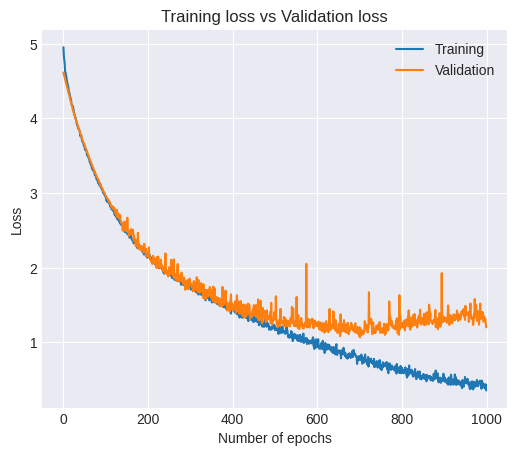

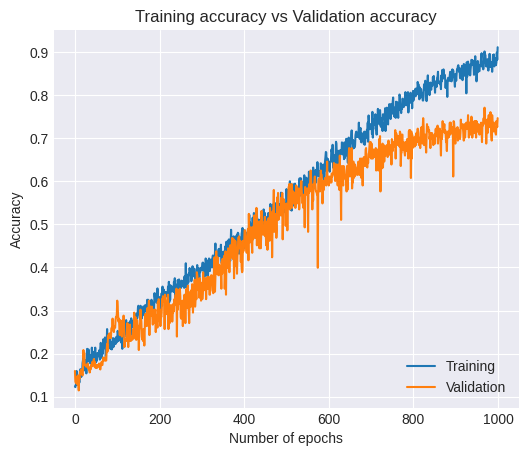

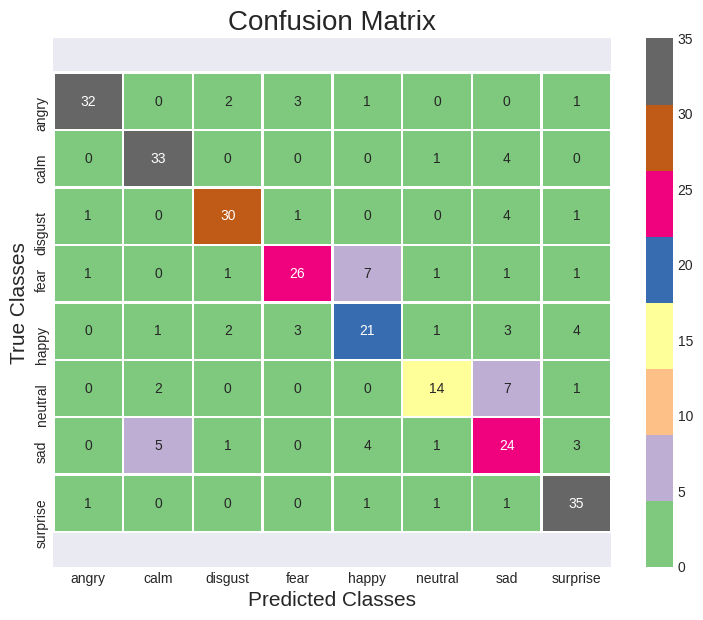

              precision    recall  f1-score   support

       angry       0.91      0.82      0.86        39
        calm       0.80      0.87      0.84        38
     disgust       0.83      0.81      0.82        37
        fear       0.79      0.68      0.73        38
       happy       0.62      0.60      0.61        35
     neutral       0.74      0.58      0.65        24
         sad       0.55      0.63      0.59        38
    surprise       0.76      0.90      0.82        39

    accuracy                           0.75       288
   macro avg       0.75      0.74      0.74       288
weighted avg       0.75      0.75      0.75       288



In [ ]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 100 
plt.figure(1,figsize=(6,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 100 
plt.figure(2,figsize=(6,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])      

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[40:50] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 150 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('Initial_Model_Confusion_Matrix-SGD-MFCC.png')
plt.show() 

print(classification_report(TRUE, predictions, target_names = ['angry','calm','disgust','fear','happy','neutral','sad','surprise'])) 

In [9]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT LOG MEL SPECTROGRAM MEAN VALUES INTO DF FOR MODELING
import pandas as pd 
df_mel = pd.DataFrame(columns=['mel_spectrogram'])

counter=0

for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
        
    # Mel-frequency cepstral coefficients (MFCCs)
#     mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
#     mfcc=np.mean(mfcc,axis=0)
    
    # compute chroma energy (pertains to 12 different pitch classes)
#     chroma = librosa.feature.chroma_stft(y=X, sr=sample_rate)
#     chroma = np.mean(chroma, axis = 0)

    # compute spectral contrast
#     contrast = librosa.feature.spectral_contrast(y=X, sr=sample_rate)
#     contrast = np.mean(contrast, axis= 0)

    # compute zero-crossing-rate (zcr:the zcr is the rate of sign changes along a signal i.e.m the rate at 
#     which the signal changes from positive to negative or back - separation of voiced andunvoiced speech.)
#     zcr = librosa.feature.zero_crossing_rate(y=X)
#     zcr = np.mean(zcr, axis= 0)
    
    df_mel.loc[counter] = [log_spectrogram]
    counter=counter+1   

print(len(df_mel))
df_mel.head()

1440


mel_spectrogram
0  [-76.38477, -76.38477, -76.38477, -76.38477, -76.38477, -76.38477, -76.38477, -76.38477, -76.38477, -76.38477, -76.38477, -76.38477, -76.38477, -76.38477, -76.38477, -76.38477, -76.367455, -76.37206, -76.38477, -76.38477, -76.17391, -75.7191, -75.94153, -75.64262, -75.90894, -75.83096, -75.7507, -74.77977, -72.83129, -71.26305, -66.522675, -66.2235, -70.02048, -72.228935, -72.31369, -73.103096, -73.700745, -74.24736, -72.63008, -70.088715, -71.00686, -71.960075, -64.49295, -45.909077, -40.032604, -41.11626, -43.53601, -40.618973, -35.053967, -32.517483, -32.09255, -32.517563, -33.537037, -33.267624, -35.378643, -40.17928, -42.373196, -43.332584, -42.339584, -40.89039, -37.12334, -35.466946, -33.28547, -32.946716, -32.992203, -33.490017, -35.94524, -41.89631, -47.815334, -50.32318, -45.502876, -38.28941, -38.666992, -41.103245, -41.816746, -42.41458, -41.487278, -39.022465, -35.519356, -33.715797, -33.540745, -34.01699, -34.09233, -32.436264, -31.850286, -33.650314, -38.19356, -42.97809, -45.402485, -45.206005, -44.586697, -45.93698, -45.795696, -40.709064, -37.872944, -38.022907, -38.164814, -39.510433, -41.684795, -42.941948, ...]
1  [-80.14738, -80.14738, -80.14738, -80.14738, -80.14738, -80.14738, -80.14738, -80.14738, -80.14738, -80.14738, -80.14738, -80.14738, -80.127945, -80.13347, -80.14738, -80.14738, -80.14738, -80.14738, -80.14738, -80.14738, -79.7419, -79.20434, -79.97592, -80.14738, -80.11814, -80.03579, -79.77556, -79.23013, -80.02082, -80.14738, -80.11845, -79.99408, -80.137436, -79.885605, -79.75465, -79.908585, -78.36221, -75.423454, -75.674515, -78.66503, -79.28208, -77.87175, -72.08605, -51.54782, -45.35818, -43.328465, -44.24703, -45.25155, -44.675232, -46.341938, -48.114025, -45.54728, -40.37463, -37.380394, -37.029106, -37.678547, -37.02678, -35.240505, -33.809, -33.707542, -34.823742, -37.815422, -42.426666, -46.150932, -49.23577, -51.59059, -52.696022, -52.036167, -52.247814, -51.311386, -49.45393, -47.494717, -46.524597, -44.75211, -43.45294, -43.357895, -42.37853, -41.48824, -42.684326, -43.235542, -44.422443, -46.62359, -49.714573, -54.31166, -58.597244, -60.863823, -62.78856, -63.813965, -46.455826, -39.372593, -40.318737, -41.96812, -42.87303, -42.81906, -42.351673, -43.013176, -43.966866, -44.977272, -46.14981, -43.878326, ...]      
2  [-79.61142, -79.61142, -79.61142, -79.61142, -79.61142, -79.61142, -79.61142, -79.61037, -79.61142, -79.5505, -79.3984, -79.58202, -79.61142, -79.61142, -79.6029, -79.60936, -79.61142, -79.6101, -79.575806, -79.36379, -79.24537, -79.572586, -79.61142, -79.10489, -78.0653, -78.34661, -79.32881, -79.61142, -79.3803, -76.99489, -69.49426, -67.420494, -71.69285, -77.55179, -78.59408, -77.33197, -76.80479, -75.728836, -73.6734, -73.63851, -73.79517, -73.320366, -53.179367, -41.105118, -39.716854, -37.36446, -34.027317, -32.77425, -31.815086, -31.81043, -31.427832, -31.59653, -32.039608, -31.864943, -32.456676, -33.20365, -33.501263, -33.637108, -34.00089, -34.49173, -34.897243, -35.60857, -37.031387, -38.84752, -38.970398, -39.801884, -42.110844, -44.887142, -48.34272, -52.338825, -54.593506, -55.26956, -48.771236, -45.475616, -46.225468, -46.426723, -46.939034, -44.739998, -42.745537, -40.823933, -37.87938, -37.48085, -38.51911, -39.358578, -39.506084, -39.92851, -40.663425, -41.11452, -40.952694, -40.562237, -40.20431, -41.169254, -42.07095, -43.064137, -43.627422, -42.979515, -41.427296, -40.834106, -42.271984, -38.925457, ...]      
3  [-75.33552, -75.44532, -75.55403, -75.20395, -75.23053, -75.319374, -75.65379, -75.72004, -75.72004, -75.72004, -75.72004, -75.72004, -75.556015, -75.11806, -75.05926, -75.37063, -75.39123, -75.65184, -75.72004, -75.72004, -75.54712, -75.30135, -75.14379, -75.14993, -75.40678, -72.989136, -65.36421, -66.2162, -71.882805, -61.773552, -55.71258, -54.201565, -59.008545, -65.38085, -71.747086, -73.44503, -74.108345, -75.11359, -75.42259, -73.35681, -71.12248, -71.671295, -72.884895, -57.994675, -46.607414, -42.76556, -42

In [10]:
# TURN ARRAY INTO LIST AND JOIN WITH AUDIO_DF TO GET CORRESPONDING EMOTION LABELS
df_combined = pd.concat([audio_df,pd.DataFrame(df_mel['mel_spectrogram'].values.tolist())],axis=1)
df_combined = df_combined.fillna(0)
# DROP PATH COLUMN FOR MODELING
df_combined.drop(columns='path',inplace=True)
# CHECK TOP 5 ROWS
df_combined.head()

gender  emotion  actor          0  ...        255        256        257        258
0  male   neutral  1     -76.384773  ...  0.000000   0.000000   0.000000   0.000000 
1  male   calm     1     -80.147377  ... -80.130417 -80.014702 -80.147377 -80.147377
2  male   calm     1     -79.611420  ... -79.611420 -79.611420 -79.611420 -79.611420
3  male   neutral  1     -75.335518  ...  0.000000   0.000000   0.000000   0.000000 
4  male   calm     1     -76.828041  ... -76.828041 -76.828041 -76.805473 -76.828041

[5 rows x 262 columns]

In [12]:
# TURN ARRAY INTO LIST AND JOIN WITH AUDIO_DF TO GET CORRESPONDING EMOTION LABELS
df_combined = pd.concat([audio_df,pd.DataFrame(df_mel['mel_spectrogram'].values.tolist())],axis=1)
df_combined = df_combined.fillna(0)
# DROP PATH COLUMN FOR MODELING
df_combined.drop(columns='path',inplace=True)
# CHECK TOP 5 ROWS
df_combined.head()
# TRAIN TEST SPLIT DATA
train,test = train_test_split(df_combined, test_size=0.20, random_state=0,
                               stratify=df_combined[['emotion','gender','actor']])
X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:2].drop(columns=['gender'])
print(X_train.shape)
X_test = test.iloc[:,3:]
y_test = test.iloc[:,:2].drop(columns=['gender'])
print(X_test.shape)
# Define the K-fold Cross Validator
kfold = KFold(n_splits=2, shuffle=True)
acc_per_fold = []
loss_per_fold = []
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(y_test[0:10])
# RESHAPE DATA TO INCLUDE 3D TENSOR 
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

print(X_train.shape)
print(X_test.shape)

inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)
inputs.shape
targets.shape

(1152, 259)
(288, 259)
[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]
(1152, 259, 1)
(288, 259, 1)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(1440, 8)

In [13]:
print(lb.classes_)

['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [15]:
# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
  model = tf.keras.Sequential()
  model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(X_train.shape[1],1)))
  model.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(8, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
  model.summary()
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  checkpoint = ModelCheckpoint("SER_best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
  model_history=model.fit(inputs[train], targets[train],batch_size=32, epochs=1000, validation_data=(X_test, y_test),callbacks=[checkpoint])
  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  # Increase fold number
  fold_no = fold_no + 1
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Streaming output truncated to the last 5000 lines.
Epoch 775/1000
23/23 [==============================] - 1s 22ms/step - loss: 0.1425 - accuracy: 0.9654 - val_loss: 1.8745 - val_accuracy: 0.7569

Epoch 00775: val_accuracy did not improve from 0.78125
Epoch 776/1000
23/23 [==============================] - 0s 21ms/step - loss: 0.1404 - accuracy: 0.9696 - val_loss: 1.8491 - val_accuracy: 0.7500

Epoch 00776: val_accuracy did not improve from 0.78125
Epoch 777/1000
23/23 [==============================] - 1s 22ms/step - loss: 0.1664 - accuracy: 0.9660 - val_loss: 1.7829 - val_accuracy: 0.7743

Epoch 00777: val_accuracy did not improve from 0.78125
Epoch 778/1000
23/23 [==============================] - 0s 21ms/step - loss: 0.1641 - accuracy: 0.9706 - val_loss: 1.8170 - val_accuracy: 0.7708

Epoch 00778: val_accuracy did not improve from 0.78125
Epoch 779/1000
23/23 [==============================] - 0s 21ms/step - loss: 0.1229 - accuracy: 0.9724 - val_loss: 1.7852 - val_accuracy: 0.7535


9/9 [==============================] - 0s 6ms/step - loss: 1.9197 - accuracy: 0.7639
Loss of the model is -  1.9197090864181519
9/9 [==============================] - 0s 5ms/step - loss: 1.9197 - accuracy: 0.7639
Accuracy of the model is -  76.38888955116272 %


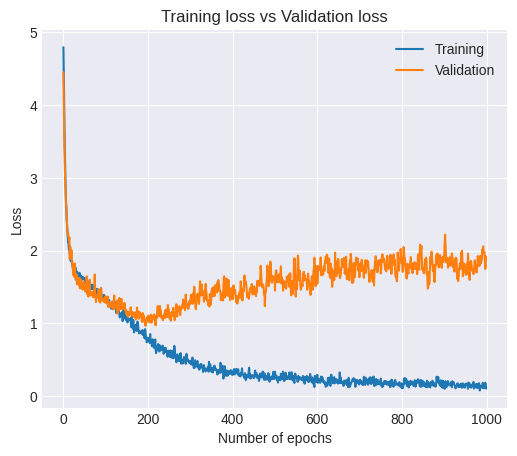

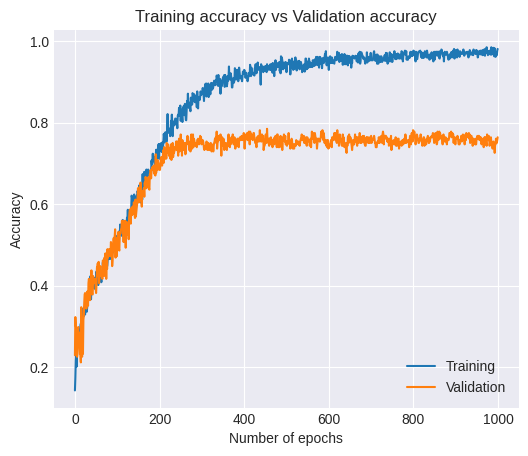

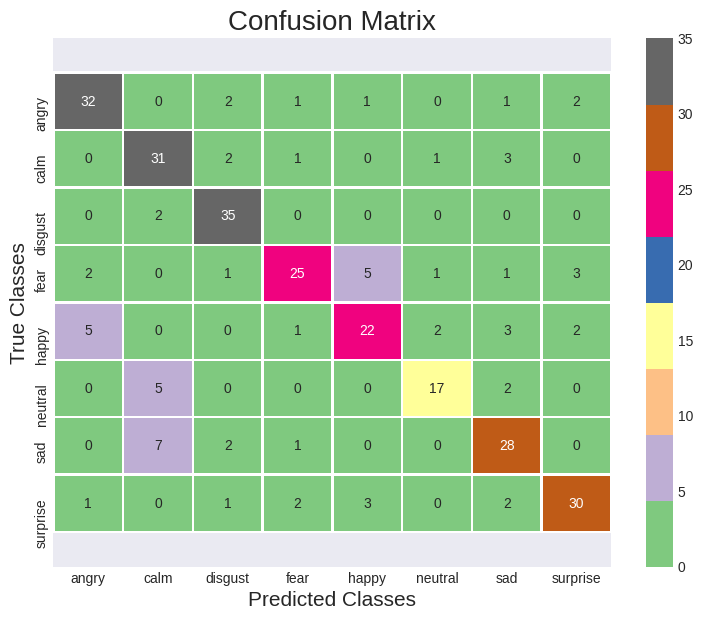

              precision    recall  f1-score   support

       angry       0.80      0.82      0.81        39
        calm       0.69      0.82      0.75        38
     disgust       0.81      0.95      0.88        37
        fear       0.81      0.66      0.72        38
       happy       0.71      0.63      0.67        35
     neutral       0.81      0.71      0.76        24
         sad       0.70      0.74      0.72        38
    surprise       0.81      0.77      0.79        39

    accuracy                           0.76       288
   macro avg       0.77      0.76      0.76       288
weighted avg       0.77      0.76      0.76       288



In [17]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 100 
plt.figure(1,figsize=(6,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 100 
plt.figure(2,figsize=(6,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])      

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[40:50] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 150 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('Initial_Model_Confusion_Matrix-SGD-MFCC.png')
plt.show() 

print(classification_report(TRUE, predictions, target_names = ['angry','calm','disgust','fear','happy','neutral','sad','surprise'])) 

In [23]:
model = tf.keras.Sequential()
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(X_train.shape[1],1)))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='SGD',metrics=['accuracy'])
model.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
model_history=model.fit(inputs[train], targets[train],batch_size=32, epochs=1000, validation_data=(X_test, y_test),callbacks=[checkpoint])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_69 (Conv1D)           (None, 259, 256)          2304      
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 252, 256)          524544    
_________________________________________________________________
max_pooling1d_61 (MaxPooling (None, 126, 256)          0         
_________________________________________________________________
batch_normalization_56 (Batc (None, 126, 256)          1024      
_________________________________________________________________
dropout_57 (Dropout)         (None, 126, 256)          0         
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 126, 256)          524544    
_________________________________________________________________
max_pooling1d_62 (MaxPooling (None, 63, 256)          

9/9 [==============================] - 0s 6ms/step - loss: 1.1595 - accuracy: 0.7292
Loss of the model is -  1.1594902276992798
9/9 [==============================] - 0s 5ms/step - loss: 1.1595 - accuracy: 0.7292
Accuracy of the model is -  72.91666865348816 %


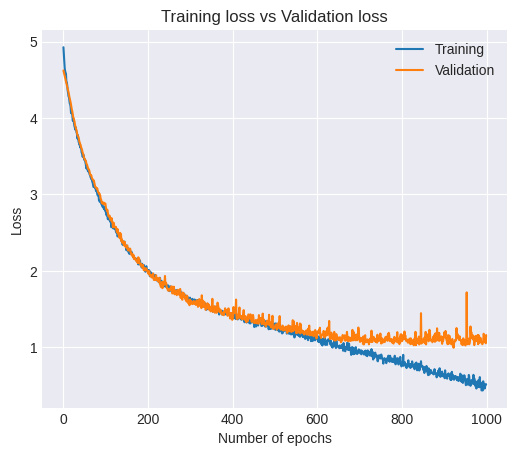

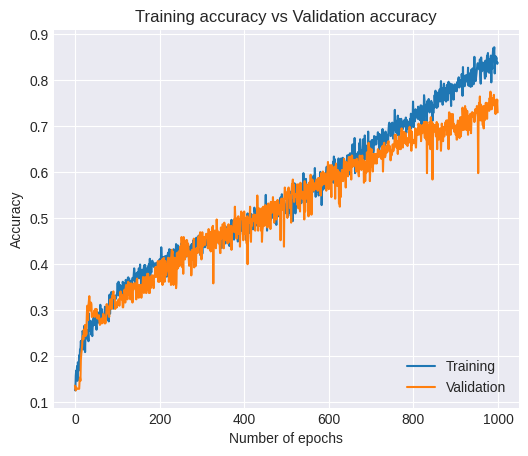

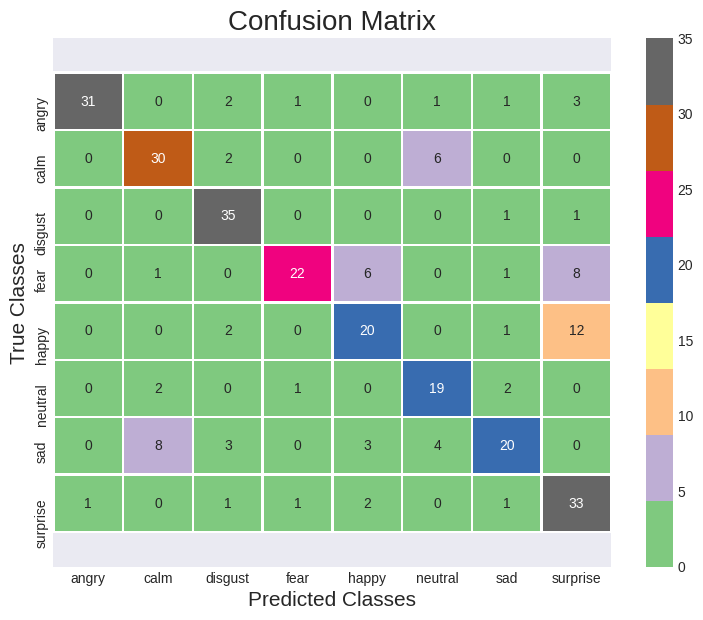

              precision    recall  f1-score   support

       angry       0.97      0.79      0.87        39
        calm       0.73      0.79      0.76        38
     disgust       0.78      0.95      0.85        37
        fear       0.88      0.58      0.70        38
       happy       0.65      0.57      0.61        35
     neutral       0.63      0.79      0.70        24
         sad       0.74      0.53      0.62        38
    surprise       0.58      0.85      0.69        39

    accuracy                           0.73       288
   macro avg       0.74      0.73      0.72       288
weighted avg       0.75      0.73      0.73       288



In [24]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 100 
plt.figure(1,figsize=(6,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 100 
plt.figure(2,figsize=(6,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])      

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[40:50] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 150 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('Initial_Model_Confusion_Matrix-SGD-SPECTROGRAM.png')
plt.show() 

print(classification_report(TRUE, predictions, target_names = ['angry','calm','disgust','fear','happy','neutral','sad','surprise'])) 

In [ ]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT MFCC MEAN VALUES INTO DF FOR MODELING
import pandas as pd 
df = pd.DataFrame(columns=['chroma'])

counter=0

for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    # Mel-frequency cepstral coefficients (MFCCs)
    #mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
    #mfcc=np.mean(mfcc,axis=0)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    #spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    #db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    #log_spectrogram = np.mean(db_spec, axis = 0)      
    
    # compute chroma energy (pertains to 12 different pitch classes)
    chroma = librosa.feature.chroma_stft(y=X, sr=sample_rate)
    chroma = np.mean(chroma, axis = 0)

    # compute spectral contrast
#     contrast = librosa.feature.spectral_contrast(y=X, sr=sample_rate)
#     contrast = np.mean(contrast, axis= 0)

    # compute zero-crossing-rate (zcr:the zcr is the rate of sign changes along a signal i.e.m the rate at 
#     which the signal changes from positive to negative or back - separation of voiced andunvoiced speech.)
#     zcr = librosa.feature.zero_crossing_rate(y=X)
#     zcr = np.mean(zcr, axis= 0)
    
    df.loc[counter] = [chroma]
    counter=counter+1   

print(len(df))
df.head()

1440


chroma
0  [0.88908386, 0.9509051, 0.9426281, 0.91884345, 0.9209737, 0.90167683, 0.7518561, 0.572593, 0.61085206, 0.7220045, 0.65889984, 0.79690653, 0.78755885, 0.8089555, 0.69948816, 0.9392457, 0.90366554, 0.90142745, 0.7356891, 0.66521645, 0.8589011, 0.87553936, 0.876715, 0.86594754, 0.7871596, 0.8869485, 0.8715053, 0.43088898, 0.4283644, 0.5891902, 0.40670893, 0.40650442, 0.38739482, 0.2991003, 0.3692523, 0.34783378, 0.4890368, 0.69495535, 0.71199566, 0.64453816, 0.7021797, 0.6797963, 0.7968411, 0.5761124, 0.4590334, 0.44940767, 0.5273414, 0.7356474, 0.57675236, 0.4002439, 0.2742905, 0.23945498, 0.26108405, 0.35000288, 0.4804099, 0.4421909, 0.5061163, 0.47110593, 0.43446016, 0.43430933, 0.56911975, 0.5957217, 0.43168405, 0.47532102, 0.5944529, 0.6049881, 0.51415795, 0.68329626, 0.54881454, 0.43103814, 0.4592086, 0.6138046, 0.70375013, 0.53036284, 0.49454904, 0.45754123, 0.49338254, 0.6833616, 0.5348631, 0.36408174, 0.29986462, 0.32781795, 0.3745958, 0.403042, 0.36861154, 0.40440246, 0.53298634, 0.6597547, 0.44805348, 0.5340584, 0.53735787, 0.5460649, 0.6654796, 0.6555174, 0.5207138, 0.39620495, 0.3163344, 0.3279068, 0.38593352, 0.38111898, ...]     
1  [0.0, 0.8028249, 0.7615967, 0.7629048, 0.8013041, 0.9504452, 0.5600762, 0.56414115, 0.6082352, 0.8834295, 0.64363515, 0.74752307, 0.8287905, 0.7670505, 0.904078, 0.6919496, 0.95043206, 0.9504326, 0.95043373, 0.7771196, 0.7270903, 0.71162516, 0.79449123, 0.75744367, 0.82331544, 0.81202716, 0.26877782, 0.26719394, 0.26918107, 0.8148675, 0.797395, 0.7368266, 0.8111582, 0.8343854, 0.79563826, 0.7647194, 0.5376623, 0.3799975, 0.4143182, 0.69882673, 0.77261657, 0.8424294, 0.7168727, 0.4804093, 0.453408, 0.36323723, 0.34937763, 0.28624997, 0.4153817, 0.42079902, 0.5714457, 0.5585047, 0.49611273, 0.41456342, 0.35033783, 0.34620366, 0.35474882, 0.38551858, 0.43364167, 0.33161458, 0.47382823, 0.46666864, 0.46545887, 0.47066072, 0.38730606, 0.53805983, 0.4826964, 0.6456918, 0.768068, 0.7571114, 0.5221848, 0.3876976, 0.31408244, 0.3778452, 0.45008802, 0.47973967, 0.5787398, 0.3516173, 0.29466504, 0.25250253, 0.23154585, 0.27127123, 0.532927, 0.61831325, 0.55319446, 0.49066374, 0.44225147, 0.5392117, 0.5195493, 0.6305972, 0.5257674, 0.5883163, 0.4355662, 0.39149556, 0.2688232, 0.21990274, 0.36044383, 0.27386174, 0.5702439, 0.46801892, ...]               
2  [0.7575856, 0.75469345, 0.75221306, 0.79296607, 0.8190005, 0.7411478, 0.8353967, 0.73491746, 0.73532265, 0.6740462, 0.77994674, 0.7536571, 0.75471324, 0.7555161, 0.769811, 0.731841, 0.8467738, 0.82774, 0.79521626, 0.6526479, 0.65312296, 0.8086615, 0.7929123, 0.75123215, 0.8347685, 0.79160285, 0.89116734, 0.89688563, 0.4122099, 0.510613, 0.32138056, 0.31676704, 0.3469412, 0.57493377, 0.7915492, 0.7373249, 0.6484081, 0.6869095, 0.7230232, 0.5709184, 0.6359337, 0.62812084, 0.6316022, 0.50106573, 0.52212673, 0.4950138, 0.3195434, 0.3285155, 0.3074759, 0.30647996, 0.48315406, 0.38459626, 0.40539488, 0.43722096, 0.34909153, 0.34329715, 0.35040936, 0.31433627, 0.26791355, 0.29997733, 0.31746906, 0.36610663, 0.3137555, 0.31906155, 0.30618718, 0.35241666, 0.2902622, 0.317451, 0.56196564, 0.56934947, 0.5368274, 0.65580595, 0.66555333, 0.71366453, 0.4462788, 0.4008439, 0.3929857, 0.39188242, 0.48825148, 0.5575842, 0.7341328, 0.5958677, 0.41904148, 0.4350628, 0.53257763, 0.515574, 0.67693263, 0.4549204, 0.5351512, 0.25478086, 0.21772347, 0.14130832, 0.15670994, 0.20713834, 0.24710314, 0.22307706, 0.2710661, 0.2708768, 0.26983508, 0.7566561, ...]        
3  [0.65444297, 0.83087367, 0.7731745, 0.89314216, 0.87699294, 0.81991386, 0.86964315, 0.8569346, 0.82444376, 0.8151169, 0.86923975, 0.7562613, 0.8156071, 0.8157355, 0.787383, 0.79685664, 0.7185123, 0.8013355, 0.8021469, 0.7712755, 0.84103894, 0.7443924, 0.84771866, 0.8217702, 0.9065966, 0.74523467, 0.68721944, 0.67459583, 0.5541744, 0.55916077, 0.4447972, 0.36225143, 0.36722603, 0.4901924, 0.6856051, 0.6419086, 0.6564872, 0.6738985, 0.7635829, 0.75306606, 0.70455027, 0.8247614, 0.81745744, 0.422988

In [ ]:
# TRAIN TEST SPLIT DATA
train,test = train_test_split(df_combined, test_size=0.20, random_state=0,
                               stratify=df_combined[['emotion','gender','actor']])
X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:2].drop(columns=['gender'])
print(X_train.shape)
X_test = test.iloc[:,3:]
y_test = test.iloc[:,:2].drop(columns=['gender'])
print(X_test.shape)
# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)
acc_per_fold = []
loss_per_fold = []
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(y_test[0:10])

(1152, 259)
(288, 259)
[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# RESHAPE DATA TO INCLUDE 3D TENSOR 
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_train.shape
X_test.shape

inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

In [ ]:
# TRAIN TEST SPLIT DATA
train,test = train_test_split(df_combined, test_size=0.20, random_state=0,
                               stratify=df_combined[['emotion','gender','actor']])
X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:2].drop(columns=['gender'])
print(X_train.shape)
X_test = test.iloc[:,3:]
y_test = test.iloc[:,:2].drop(columns=['gender'])
print(X_test.shape)
# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)
acc_per_fold = []
loss_per_fold = []
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(y_test[0:10])

(1152, 259)
(288, 259)
[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT MFCC MEAN VALUES INTO DF FOR MODELING
import pandas as pd 
df = pd.DataFrame(columns=['contrast'])

counter=0

for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    # Mel-frequency cepstral coefficients (MFCCs)
    #mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
    #mfcc=np.mean(mfcc,axis=0)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    #spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    #db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    #log_spectrogram = np.mean(db_spec, axis = 0)      
    
    # compute chroma energy (pertains to 12 different pitch classes)
    # chroma = librosa.feature.chroma_stft(y=X, sr=sample_rate)
    # chroma = np.mean(chroma, axis = 0)

    # compute spectral contrast
    contrast = librosa.feature.spectral_contrast(y=X, sr=sample_rate)
    contrast = np.mean(contrast, axis= 0)

    # compute zero-crossing-rate (zcr:the zcr is the rate of sign changes along a signal i.e.m the rate at 
#     which the signal changes from positive to negative or back - separation of voiced andunvoiced speech.)
#     zcr = librosa.feature.zero_crossing_rate(y=X)
#     zcr = np.mean(zcr, axis= 0)
    
    df.loc[counter] = [contrast]
    counter=counter+1   

print(len(df))
df.head()

1440


contrast
0  [15.823533536951393, 3.8799662212872588, 11.129631826786794, 12.989010285599775, 14.069355331542434, 14.2244797710423, 12.094505410869298, 11.853278727153603, 12.43023083948899, 13.55924188089972, 10.932942653926053, 9.717542364043695, 9.901391222819177, 12.068309857410416, 14.319005526011864, 11.345093118022044, 11.319684101145652, 11.575603085586405, 13.755124234742963, 12.89173803167652, 11.971622248023271, 13.298229416146436, 14.08018195819278, 12.309959251822294, 14.797366289046462, 11.884316401612145, 13.275202113892325, 14.905215372401932, 14.286063824222778, 16.506415776756604, 17.229153207634415, 19.100938491300603, 17.60897890073887, 18.870985886693436, 17.787303223538743, 16.66653040087162, 14.629041817278496, 16.379293215142713, 14.12478240821802, 16.21184347845133, 15.994016125310555, 16.08555662221891, 13.537094000423092, 16.616643811946318, 18.144486933825824, 22.720531969328054, 17.953910170332584, 17.740540457776248, 21.467661415769932, 23.68429120319796, 26.51249790523362, 27.09101927407951, 26.152054561980815, 25.172214794834698, 21.416831121236502, 24.303415339241855, 22.259095228399566, 22.54762725991815, 19.645340723778848, 19.332856072149088, 19.80431452067938, 22.349571093126663, 25.11190422330007, 22.6837232620993, 21.415503579515708, 22.0842984364146, 20.637212964508144, 18.955872107081714, 20.418834611953994, 17.931442040482573, 17.662958118555597, 15.92672854322454, 22.096151419270566, 18.491601651316085, 18.991914948924517, 19.58191637891216, 18.887633151428954, 19.7851060664079, 18.36224731853803, 21.18375577687166, 24.154172692376477, 21.892211308676774, 23.190638358044428, 21.206199100760436, 19.80978957572979, 20.371875270441766, 20.789985334482793, 18.048497779957138, 19.650401870285304, 18.66723992796051, 18.344862073210358, 17.32238718196874, 19.841382391130423, 21.798190558926557, 22.013898921201257, 24.573975512564864, 21.44084526692271, 19.69404115157402, 21.66379983079767, 20.592368788142988, ...]   
1  [10.66167804206249, 6.640794406719947, 9.074295569437464, 8.83942543567071, 10.397823834366632, 3.466004676793116, 11.395255468350248, 10.882259223328589, 9.96504498882887, 8.992485505997681, 11.225551414444043, 11.618095519046127, 18.4072883690616, 12.201348911390323, 13.345386060401946, 9.629487295172227, 3.3454352179169606, 3.3831867600660033, 3.3987721181457835, 11.175589124702276, 10.465483809745374, 10.901053725603033, 12.696723242257386, 12.294079686015802, 13.776569285710297, 12.070266163348817, 13.112249168395902, 11.653021174881493, 14.121097507775833, 14.178432741042096, 12.10125021046315, 12.955945137675489, 13.899538213942218, 13.040849284552658, 11.725874318970739, 12.362224600609336, 14.558657638037015, 15.350266771805687, 13.963999444240404, 14.361410219028906, 13.404018608232978, 12.758789334785234, 12.830688639279558, 15.23990488513296, 17.598121835440047, 19.257715763087788, 19.916435234583624, 16.14682184806739, 20.724993891923045, 19.817720598553475, 19.174463737264073, 20.04424718134514, 23.09317420694494, 25.31726402468592, 26.645360515828806, 26.719161108063187, 27.597473386221733, 25.94271329835031, 24.211588989013585, 25.00093359013379, 24.804494735621226, 21.921410889467484, 20.877443470984737, 20.376715887984783, 22.054532545197187, 20.497577257080284, 20.386929006561747, 20.942247101268226, 19.595803667875632, 19.48852727002498, 19.08020947914327, 19.174675739448617, 20.626349806787896, 19.786541222366395, 18.018385277620073, 17.6691586927443, 19.606600153194243, 20.542084738500563, 19.11764331259732, 20.677892649373003, 20.395469757867627, 19.621867994081907, 20.865643991239008, 18.99242097359417, 19.911494055293854, 18.241854494743894, 16.657836002386297, 18.975636153953747, 17.099408387532936, 20.14694105444492, 18.831299618833846, 19.34664156050606, 16.60307544983655, 17.029076156637903, 17.167260878312224, 17.47243702055965, 20.189890251445124, 20.416995616465943, 20.14347662385692, 20.9702187493472, ...] 
2  [20.91600444124443, 9.938549954434

In [ ]:
# TURN ARRAY INTO LIST AND JOIN WITH AUDIO_DF TO GET CORRESPONDING EMOTION LABELS
df_combined = pd.concat([audio_df,pd.DataFrame(df['contrast'].values.tolist())],axis=1)
df_combined = df_combined.fillna(0)
# DROP PATH COLUMN FOR MODELING
df_combined.drop(columns='path',inplace=True)
# CHECK TOP 5 ROWS
df_combined.head()

gender  emotion  actor          0  ...        255        256        257        258
0  male   neutral  1      15.823534  ...  0.000000   0.000000   0.000000   0.000000 
1  male   calm     1      10.661678  ...  14.150054  11.131498  10.923022  8.665058 
2  male   calm     1      20.916004  ...  11.051191  12.978727  13.450683  8.674259 
3  male   neutral  1      19.597067  ...  0.000000   0.000000   0.000000   0.000000 
4  male   calm     1      16.069131  ...  12.913207  13.905281  12.373385  11.297862

[5 rows x 262 columns]

In [ ]:
# RESHAPE DATA TO INCLUDE 3D TENSOR 
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_train.shape
X_test.shape

inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

In [ ]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT MFCC MEAN VALUES INTO DF FOR MODELING
import pandas as pd 
df = pd.DataFrame(columns=['zcr'])

counter=0

for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    zcr = librosa.feature.zero_crossing_rate(y=X)
    zcr = np.mean(zcr, axis= 0)
    # Mel-frequency cepstral coefficients (MFCCs)
    #mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
    #mfcc=np.mean(mfcc,axis=0)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    #spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    #db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    #log_spectrogram = np.mean(db_spec, axis = 0)      
    
    # compute chroma energy (pertains to 12 different pitch classes)
    # chroma = librosa.feature.chroma_stft(y=X, sr=sample_rate)
    # chroma = np.mean(chroma, axis = 0)

    # compute spectral contrast
    #contrast = librosa.feature.spectral_contrast(y=X, sr=sample_rate)
    #contrast = np.mean(contrast, axis= 0)

    # compute zero-crossing-rate (zcr:the zcr is the rate of sign changes along a signal i.e.m the rate at 
#     which the signal changes from positive to negative or back - separation of voiced andunvoiced speech.)
      
    
    df.loc[counter] = [zcr]
    counter=counter+1   

print(len(df))
df.head()

1440


zcr
0  [0.0126953125, 0.025390625, 0.037109375, 0.0498046875, 0.048828125, 0.0478515625, 0.109375, 0.1201171875, 0.126953125, 0.115234375, 0.05810546875, 0.0546875, 0.0615234375, 0.0615234375, 0.056640625, 0.1025390625, 0.09228515625, 0.1376953125, 0.1640625, 0.16552734375, 0.271484375, 0.35791015625, 0.4326171875, 0.50732421875, 0.5166015625, 0.5380859375, 0.56201171875, 0.57861328125, 0.611328125, 0.5595703125, 0.5146484375, 0.43701171875, 0.36328125, 0.35693359375, 0.369140625, 0.40087890625, 0.4453125, 0.42529296875, 0.41064453125, 0.40673828125, 0.375, 0.423828125, 0.39599609375, 0.34765625, 0.3134765625, 0.25146484375, 0.2080078125, 0.15380859375, 0.09130859375, 0.0400390625, 0.0283203125, 0.02734375, 0.0263671875, 0.0234375, 0.02294921875, 0.02099609375, 0.05517578125, 0.09375, 0.13525390625, 0.16357421875, 0.1376953125, 0.1044921875, 0.0703125, 0.0556640625, 0.0537109375, 0.05078125, 0.0458984375, 0.0390625, 0.03466796875, 0.037109375, 0.08984375, 0.14208984375, 0.17919921875, 0.20166015625, 0.17333984375, 0.12890625, 0.09228515625, 0.064453125, 0.0380859375, 0.02685546875, 0.025390625, 0.02978515625, 0.033203125, 0.03369140625, 0.03662109375, 0.03515625, 0.03564453125, 0.044921875, 0.0546875, 0.0712890625, 0.09912109375, 0.09423828125, 0.08056640625, 0.06103515625, 0.0283203125, 0.0234375, 0.02197265625, 0.0185546875, 0.015625, 0.01123046875, ...]                              
1  [0.0, 0.0302734375, 0.0302734375, 0.0419921875, 0.0419921875, 0.01171875, 0.0478515625, 0.0478515625, 0.0478515625, 0.08203125, 0.1083984375, 0.134765625, 0.18359375, 0.1494140625, 0.0869140625, 0.048828125, 0.01171875, 0.01171875, 0.01171875, 0.080078125, 0.1201171875, 0.1669921875, 0.216796875, 0.2568359375, 0.2705078125, 0.33447265625, 0.41357421875, 0.375, 0.40185546875, 0.359375, 0.3134765625, 0.2568359375, 0.263671875, 0.2626953125, 0.2783203125, 0.40625, 0.45068359375, 0.5185546875, 0.5263671875, 0.52880859375, 0.5478515625, 0.56201171875, 0.53173828125, 0.44384765625, 0.33642578125, 0.24169921875, 0.22216796875, 0.2236328125, 0.21484375, 0.18798828125, 0.134765625, 0.08203125, 0.041015625, 0.01953125, 0.02099609375, 0.0234375, 0.025390625, 0.0244140625, 0.02294921875, 0.0205078125, 0.01904296875, 0.02001953125, 0.0205078125, 0.0185546875, 0.01416015625, 0.01171875, 0.01953125, 0.02880859375, 0.0615234375, 0.13427734375, 0.197265625, 0.27197265625, 0.31298828125, 0.30810546875, 0.287109375, 0.220703125, 0.14892578125, 0.0849609375, 0.03369140625, 0.01708984375, 0.021484375, 0.0205078125, 0.02099609375, 0.0322265625, 0.033203125, 0.0546875, 0.056640625, 0.0712890625, 0.11083984375, 0.13623046875, 0.162109375, 0.15869140625, 0.13818359375, 0.1171875, 0.1142578125, 0.1162109375, 0.10693359375, 0.08447265625, 0.0615234375, 0.041015625, ...]                                    
2  [0.0322265625, 0.068359375, 0.134765625, 0.1357421875, 0.171875, 0.18359375, 0.1962890625, 0.1630859375, 0.1953125, 0.240234375, 0.1611328125, 0.19921875, 0.16650390625, 0.13330078125, 0.19140625, 0.1767578125, 0.2021484375, 0.189453125, 0.1982421875, 0.21875, 0.2041015625, 0.1826171875, 0.20703125, 0.2646484375, 0.35107421875, 0.37646484375, 0.38720703125, 0.4189453125, 0.41943359375, 0.4873046875, 0.51123046875, 0.51171875, 0.5263671875, 0.56884765625, 0.53662109375, 0.54638671875, 0.50537109375, 0.44482421875, 0.44140625, 0.37841796875, 0.37744140625, 0.35595703125, 0.28466796875, 0.2080078125, 0.10400390625, 0.03173828125, 0.0185546875, 0.025390625, 0.02880859375, 0.033203125, 0.0390625, 0.0390625, 0.03955078125, 0.0400390625, 0.03955078125, 0.037109375, 0.037109375, 0.03369140625, 0.029296875, 0.02880859375, 0.02734375, 0.0263671875, 0.02587890625, 0.0234375, 0.0224609375, 0.02001953125, 0.0185546875, 0.01806640625, 0.01513671875, 0.0126953125, 0.009765625, 0.01953125, 0.08642578125, 0.15625, 0.236328125, 0.28955078125, 0.28125, 0.27001953125, 0.2099609375, 0.14892578125, 0.0927734375, 0.037109375, 0.0205078125, 0.021484375, 0.03466796875, 0.052734375, 0.09521

In [ ]:
# TURN ARRAY INTO LIST AND JOIN WITH AUDIO_DF TO GET CORRESPONDING EMOTION LABELS
df_combined = pd.concat([audio_df,pd.DataFrame(df['mel_spectrogram'].values.tolist())],axis=1)
df_combined = df_combined.fillna(0)
# DROP PATH COLUMN FOR MODELING
df_combined.drop(columns='path',inplace=True)
# CHECK TOP 5 ROWS
df_combined.head()
# TRAIN TEST SPLIT DATA
train,test = train_test_split(df_combined, test_size=0.20, random_state=0,
                               stratify=df_combined[['emotion','gender','actor']])
X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:2].drop(columns=['gender'])
print(X_train.shape)
X_test = test.iloc[:,3:]
y_test = test.iloc[:,:2].drop(columns=['gender'])
print(X_test.shape)
# Define the K-fold Cross Validator
kfold = KFold(n_splits=2, shuffle=True)
acc_per_fold = []
loss_per_fold = []
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(y_test[0:10])
# RESHAPE DATA TO INCLUDE 3D TENSOR 
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

print(X_train.shape)
print(X_test.shape)

inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)
inputs.shape
targets.shape

(1152, 259)
(288, 259)
[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]
(1152, 259, 1)
(288, 259, 1)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(1440, 8)

In [ ]:
# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
  model = tf.keras.Sequential()
  model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(X_train.shape[1],1)))
  model.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Conv1D(64, kernel_size=(5),strides=1,dilation_rate=1,padding="same",activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=(2)))
  model.add(BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(8, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
  model.summary()
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  checkpoint = ModelCheckpoint("SER_best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
  model_history=model.fit(inputs[train], targets[train],batch_size=32, epochs=1000, validation_data=(X_test, y_test),callbacks=[checkpoint])
  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  # Increase fold number
  fold_no = fold_no + 1
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Streaming output truncated to the last 5000 lines.
Epoch 775/1000
23/23 [==============================] - 1s 26ms/step - loss: 0.2017 - accuracy: 0.9567 - val_loss: 1.9597 - val_accuracy: 0.7396

Epoch 00775: val_accuracy did not improve from 0.77778
Epoch 776/1000
23/23 [==============================] - 1s 27ms/step - loss: 0.1826 - accuracy: 0.9680 - val_loss: 1.7620 - val_accuracy: 0.7604

Epoch 00776: val_accuracy did not improve from 0.77778
Epoch 777/1000
23/23 [==============================] - 1s 26ms/step - loss: 0.1256 - accuracy: 0.9723 - val_loss: 1.8262 - val_accuracy: 0.7431

Epoch 00777: val_accuracy did not improve from 0.77778
Epoch 778/1000
23/23 [==============================] - 1s 27ms/step - loss: 0.1467 - accuracy: 0.9707 - val_loss: 1.9759 - val_accuracy: 0.7222

Epoch 00778: val_accuracy did not improve from 0.77778
Epoch 779/1000
23/23 [==============================] - 1s 27ms/step - loss: 0.1695 - accuracy: 0.9760 - val_loss: 2.1589 - val_accuracy: 0.7361


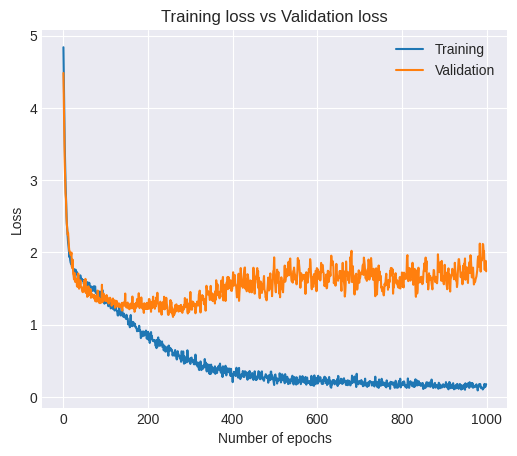

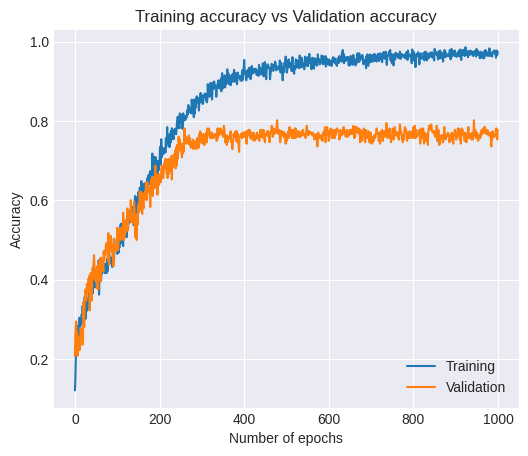

In [ ]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 100 
plt.figure(1,figsize=(6,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 100 
plt.figure(2,figsize=(6,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])      

9/9 [==============================] - 0s 10ms/step - loss: 1.7383 - accuracy: 0.7778
Loss of the model is -  1.7383455038070679
9/9 [==============================] - 0s 10ms/step - loss: 1.7383 - accuracy: 0.7778
Accuracy of the model is -  77.77777910232544 %


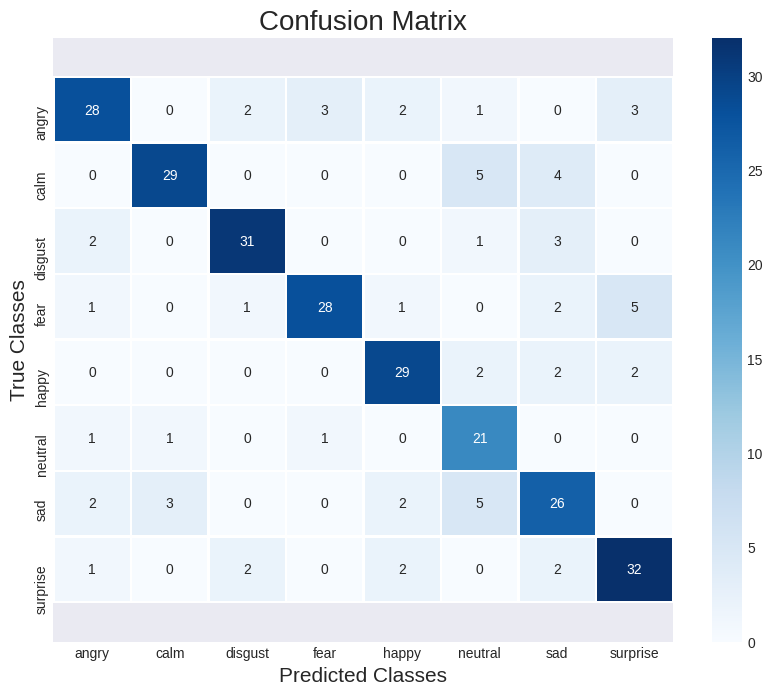

In [ ]:
# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[40:50] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (10, 8))
plt.rcParams['figure.dpi'] = 200 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('Initial_Model_Confusion_Matrix-SGD-CHROMA.png')
plt.show() 

In [ ]:
print(classification_report(TRUE, predictions, target_names = ['angry','calm','disgust','fear','happy','neutral','sad','surprise']))

              precision    recall  f1-score   support

       angry       0.80      0.72      0.76        39
        calm       0.88      0.76      0.82        38
     disgust       0.86      0.84      0.85        37
        fear       0.88      0.74      0.80        38
       happy       0.81      0.83      0.82        35
     neutral       0.60      0.88      0.71        24
         sad       0.67      0.68      0.68        38
    surprise       0.76      0.82      0.79        39

    accuracy                           0.78       288
   macro avg       0.78      0.78      0.78       288
weighted avg       0.79      0.78      0.78       288



In [ ]:
# PREDICTION LABELS
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'True Values': TRUE})

# COMBINE PREDICTION AND TRUE LABELS
finaldf = TRUE.join(predictions)
finaldf[100:150] 

True Values Predicted Values
100  disgust     sad            
101  surprise    surprise       
102  fear        surprise       
103  neutral     neutral        
104  sad         sad            
105  fear        fear           
106  angry       angry          
107  surprise    surprise       
108  disgust     disgust        
109  sad         sad            
110  disgust     disgust        
111  sad         neutral        
112  surprise    disgust        
113  fear        fear           
114  calm        calm           
115  neutral     neutral        
116  disgust     disgust        
117  fear        happy          
118  calm        sad            
119  fear        fear           
120  calm        calm           
121  calm        calm           
122  calm        calm           
123  happy       happy          
124  sad         sad            
125  disgust     disgust        
126  neutral     neutral        
127  disgust     neutral        
128  calm        calm           
129  happy       neutral        
130  happy       happy          
131  surprise    surprise       
132  happy       happy          
133  disgust     disgust        
134  sad         sad            
135  calm        neutral        
136  disgust     disgust        
137  neutral     neutral        
138  sad         sad            
139  fear        fear           
140  sad         sad            
141  surprise    surprise       
142  neutral     neutral        
143  sad         sad            
144  fear        fear           
145  sad         happy          
146  disgust     disgust        
147  angry       angry          
148  surprise    surprise       
149  angry       angry

In [ ]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT MFCC MEAN VALUES INTO DF FOR MODELING
import pandas as pd 
df = pd.DataFrame(columns=['mfcc'])

counter=0

for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    # Mel-frequency cepstral coefficients (MFCCs)
    mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
    mfcc=np.mean(mfcc,axis=0)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    #spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    #db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    #log_spectrogram = np.mean(db_spec, axis = 0)      
    
    # compute chroma energy (pertains to 12 different pitch classes)
#     chroma = librosa.feature.chroma_stft(y=X, sr=sample_rate)
#     chroma = np.mean(chroma, axis = 0)

    # compute spectral contrast
#     contrast = librosa.feature.spectral_contrast(y=X, sr=sample_rate)
#     contrast = np.mean(contrast, axis= 0)

    # compute zero-crossing-rate (zcr:the zcr is the rate of sign changes along a signal i.e.m the rate at 
#     which the signal changes from positive to negative or back - separation of voiced andunvoiced speech.)
#     zcr = librosa.feature.zero_crossing_rate(y=X)
#     zcr = np.mean(zcr, axis= 0)
    
    df.loc[counter] = [mfcc]
    counter=counter+1   

print(len(df))
df.head()

1440


mfcc
0  [-65.80097, -65.80097, -65.80097, -65.80097, -65.80097, -65.80097, -65.80097, -65.80097, -65.80097, -65.80097, -65.80097, -65.80097, -65.80097, -65.80097, -65.80097, -65.80097, -65.79317, -65.80097, -65.80097, -65.80097, -63.896137, -60.06334, -61.391453, -59.506573, -61.304344, -60.47944, -59.622013, -59.31296, -56.807724, -57.467476, -54.780277, -54.33812, -56.67149, -56.021694, -55.159336, -55.876816, -56.127678, -56.435852, -55.660587, -53.22207, -52.017757, -51.894783, -48.247776, -36.872196, -34.63617, -35.332005, -35.97329, -29.694712, -25.790712, -25.337917, -26.04528, -26.533817, -25.579006, -23.874899, -24.262552, -26.132225, -27.260983, -27.198997, -27.877888, -28.448301, -27.748417, -26.44417, -25.269634, -24.475765, -24.007607, -24.083933, -24.724846, -26.4546, -29.186512, -31.163918, -30.411167, -29.63747, -31.555855, -31.773363, -34.2731, -34.29119, -30.010237, -27.754906, -26.995674, -28.3454, -29.476929, -28.65847, -28.281578, -27.731453, -26.625526, -25.776878, -27.227072, -30.215084, -32.357243, -33.921707, -34.512356, -38.663723, -31.177103, -27.843431, -27.614267, -27.758303, -25.314016, -24.831871, -26.060616, -24.967323, ...]       
1  [-70.26777, -70.26777, -70.26777, -70.26777, -70.26777, -70.26777, -70.26777, -70.26777, -70.26777, -70.26777, -70.26777, -70.26777, -70.00066, -69.98083, -70.26777, -70.26777, -70.26777, -70.26777, -70.26777, -70.26777, -66.09639, -63.39728, -68.259895, -70.26777, -69.665245, -68.81713, -66.11466, -63.901035, -68.62062, -70.26777, -69.64199, -68.42016, -70.04418, -67.23247, -66.35039, -68.50346, -66.57759, -62.98096, -62.69349, -65.90668, -67.47967, -65.50775, -60.183018, -46.305138, -42.03026, -41.176853, -40.39396, -42.781784, -41.630405, -42.38596, -35.06297, -29.963024, -27.710716, -28.12929, -29.228241, -28.922142, -29.863792, -29.137327, -27.562275, -26.559965, -27.29548, -25.76872, -26.59623, -26.585436, -27.215006, -27.260408, -29.628487, -28.612774, -29.271511, -29.694263, -30.584787, -31.252563, -31.215956, -31.923744, -32.84927, -32.42957, -28.261763, -26.577507, -28.145658, -28.639492, -29.120243, -30.14143, -31.6785, -33.357437, -36.92599, -37.68963, -38.747364, -39.802963, -36.427456, -34.17576, -33.679245, -35.412712, -35.74091, -37.221058, -38.811974, -37.915447, -36.90479, -36.520035, -31.522871, -29.419628, ...]                         
2  [-69.67329, -69.693306, -69.693306, -69.693306, -69.693306, -69.693306, -69.693306, -69.62077, -69.693306, -68.90657, -67.25143, -69.33355, -69.693306, -69.693306, -69.64757, -69.679306, -69.693306, -69.58893, -69.181244, -66.81849, -65.78479, -69.06355, -69.693306, -64.03848, -58.784462, -59.41652, -66.427635, -69.693306, -67.02764, -62.696476, -58.7794, -59.776413, -59.815422, -63.297573, -63.207493, -60.560482, -60.138103, -59.228004, -55.83927, -55.880684, -55.55764, -54.28214, -45.284294, -33.580116, -27.007612, -23.8461, -23.520456, -23.534494, -24.046532, -23.93682, -23.998068, -23.084843, -24.058361, -24.131268, -24.922611, -24.127537, -24.819418, -24.67441, -24.9374, -26.121553, -25.321491, -25.693386, -26.929605, -28.770864, -29.116423, -29.764034, -29.929077, -31.487223, -30.5484, -31.0623, -30.9809, -32.36285, -31.64961, -33.197414, -32.953857, -32.70321, -34.101414, -36.73828, -34.659702, -29.57563, -25.832706, -25.116682, -25.818705, -23.860353, -23.747295, -23.945332, -25.148958, -24.836567, -26.031755, -27.392134, -28.862919, -29.91248, -31.504059, -32.32983, -32.843163, -33.3809, -35.17451, -34.72634, -32.610207, -27.00693, ...]          
3  [-61.84994, -62.89504, -63.830635, -60.552586, -60.82168, -62.0734, -64.88923, -65.389946, -65.389946, -65.389946, -65.389946, -65.389946, -63.679653, -59.562466, -59.068306, -62.143024, -62.43146, -64.84182, -65.389946, -65.389946, -63.86984, -61.360493, -59.707012, -59.79804, -62.271156, -60.549892, -58.221012, -58.358536, -60.64837, -53.25378, -51.222225, -49.67905, -51.87568, -56.024105, -57.659172, -58.432064, -58.607403, -60.929775, -64.41891, -58.209

In [ ]:
# TURN ARRAY INTO LIST AND JOIN WITH AUDIO_DF TO GET CORRESPONDING EMOTION LABELS
df_combined = pd.concat([audio_df,pd.DataFrame(df['mfcc'].values.tolist())],axis=1)
df_combined = df_combined.fillna(0)
# DROP PATH COLUMN FOR MODELING
df_combined.drop(columns='path',inplace=True)
# CHECK TOP 5 ROWS
df_combined.head()
# TRAIN TEST SPLIT DATA
train,test = train_test_split(df_combined, test_size=0.20, random_state=0,
                               stratify=df_combined[['emotion','gender','actor']])
X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:2].drop(columns=['gender'])
print(X_train.shape)
X_test = test.iloc[:,3:]
y_test = test.iloc[:,:2].drop(columns=['gender'])
print(X_test.shape)
# Define the K-fold Cross Validator
kfold = KFold(n_splits=4, shuffle=True)
acc_per_fold = []
loss_per_fold = []
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(y_test[0:10])
# RESHAPE DATA TO INCLUDE 3D TENSOR 
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

print(X_train.shape)
print(X_test.shape)

inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)
inputs.shape
targets.shape

(1152, 259)
(288, 259)
[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]
(1152, 259, 1)
(288, 259, 1)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(1440, 8)

In [ ]:
 
model = tf.keras.Sequential()
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(X_train.shape[1],1)))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(64, kernel_size=(5),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
model_history=model.fit(inputs[train], targets[train],batch_size=32, epochs=1000, validation_data=(X_test, y_test),callbacks=[checkpoint])
  

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_294 (Conv1D)          (None, 259, 256)          2304      
_________________________________________________________________
conv1d_295 (Conv1D)          (None, 252, 256)          524544    
_________________________________________________________________
max_pooling1d_257 (MaxPoolin (None, 126, 256)          0         
_________________________________________________________________
batch_normalization_242 (Bat (None, 126, 256)          1024      
_________________________________________________________________
dropout_283 (Dropout)        (None, 126, 256)          0         
_________________________________________________________________
conv1d_296 (Conv1D)          (None, 126, 256)          524544    
_________________________________________________________________
max_pooling1d_258 (MaxPoolin (None, 63, 256)         

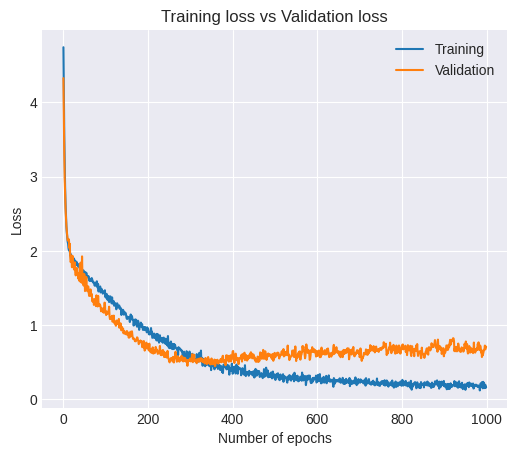

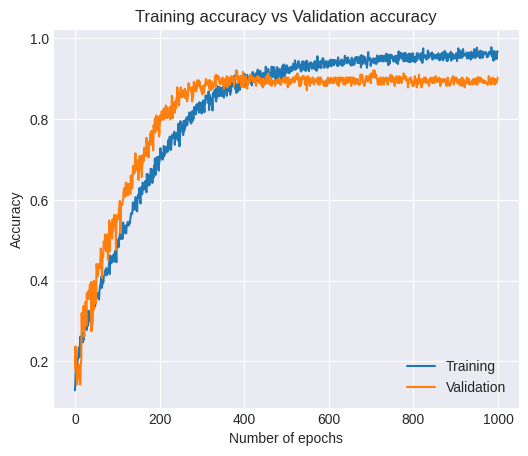

In [ ]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 100 
plt.figure(1,figsize=(6,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 100 
plt.figure(2,figsize=(6,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])       

9/9 [==============================] - 0s 10ms/step - loss: 0.7045 - accuracy: 0.9028
Loss of the model is -  0.7045125365257263
9/9 [==============================] - 0s 9ms/step - loss: 0.7045 - accuracy: 0.9028
Accuracy of the model is -  90.27777910232544 %


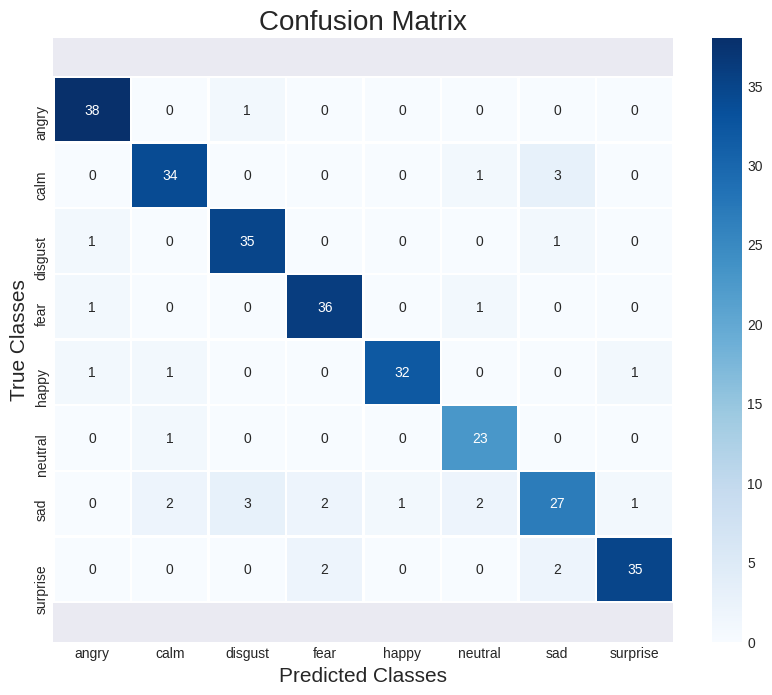

In [ ]:
# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[40:50] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (10, 8))
plt.rcParams['figure.dpi'] = 200 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('Initial_Model_Confusion_Matrix-SGD-CHROMA.png')
plt.show() 

In [ ]:
print(classification_report(TRUE, predictions, target_names = ['angry','calm','disgust','fear','happy','neutral','sad','surprise']))

              precision    recall  f1-score   support

       angry       0.93      0.97      0.95        39
        calm       0.89      0.89      0.89        38
     disgust       0.90      0.95      0.92        37
        fear       0.90      0.95      0.92        38
       happy       0.97      0.91      0.94        35
     neutral       0.85      0.96      0.90        24
         sad       0.82      0.71      0.76        38
    surprise       0.95      0.90      0.92        39

    accuracy                           0.90       288
   macro avg       0.90      0.91      0.90       288
weighted avg       0.90      0.90      0.90       288



In [ ]:
# PREDICTION LABELS
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'True Values': TRUE})

# COMBINE PREDICTION AND TRUE LABELS
finaldf = TRUE.join(predictions)
finaldf[100:150] 

True Values Predicted Values
100  disgust     disgust        
101  surprise    surprise       
102  fear        fear           
103  neutral     neutral        
104  sad         sad            
105  fear        fear           
106  angry       angry          
107  surprise    surprise       
108  disgust     disgust        
109  sad         sad            
110  disgust     disgust        
111  sad         neutral        
112  surprise    surprise       
113  fear        fear           
114  calm        calm           
115  neutral     neutral        
116  disgust     disgust        
117  fear        fear           
118  calm        calm           
119  fear        fear           
120  calm        calm           
121  calm        calm           
122  calm        calm           
123  happy       happy          
124  sad         sad            
125  disgust     angry          
126  neutral     neutral        
127  disgust     disgust        
128  calm        calm           
129  happy       calm           
130  happy       happy          
131  surprise    surprise       
132  happy       happy          
133  disgust     disgust        
134  sad         sad            
135  calm        calm           
136  disgust     disgust        
137  neutral     neutral        
138  sad         sad            
139  fear        fear           
140  sad         sad            
141  surprise    surprise       
142  neutral     neutral        
143  sad         disgust        
144  fear        fear           
145  sad         sad            
146  disgust     disgust        
147  angry       angry          
148  surprise    surprise       
149  angry       angry

In [ ]:
 
model = tf.keras.Sequential()
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(X_train.shape[1],1)))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(64, kernel_size=(5),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
model_history=model.fit(inputs[train], targets[train],batch_size=32, epochs=1500, validation_data=(X_test, y_test),callbacks=[checkpoint])

Streaming output truncated to the last 5000 lines.
Epoch 251/1500
34/34 [==============================] - 1s 24ms/step - loss: 0.6244 - accuracy: 0.8098 - val_loss: 0.6165 - val_accuracy: 0.8611

Epoch 00251: val_accuracy did not improve from 0.88194
Epoch 252/1500
34/34 [==============================] - 1s 24ms/step - loss: 0.6417 - accuracy: 0.8441 - val_loss: 0.6874 - val_accuracy: 0.8472

Epoch 00252: val_accuracy did not improve from 0.88194
Epoch 253/1500
34/34 [==============================] - 1s 24ms/step - loss: 0.6374 - accuracy: 0.8289 - val_loss: 0.7089 - val_accuracy: 0.8576

Epoch 00253: val_accuracy did not improve from 0.88194
Epoch 254/1500
34/34 [==============================] - 1s 24ms/step - loss: 0.5708 - accuracy: 0.8484 - val_loss: 0.7068 - val_accuracy: 0.8611

Epoch 00254: val_accuracy did not improve from 0.88194
Epoch 255/1500
34/34 [==============================] - 1s 24ms/step - loss: 0.6370 - accuracy: 0.8308 - val_loss: 0.6292 - val_accuracy: 0.8681


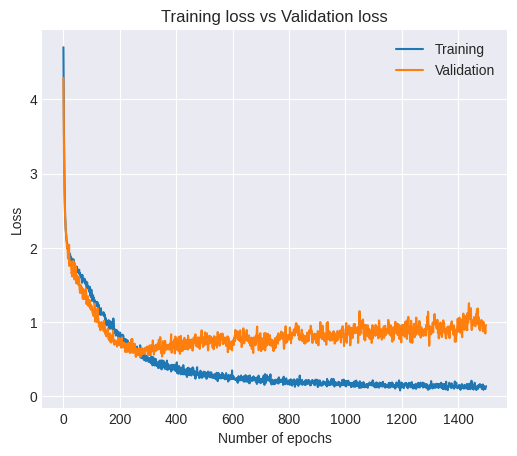

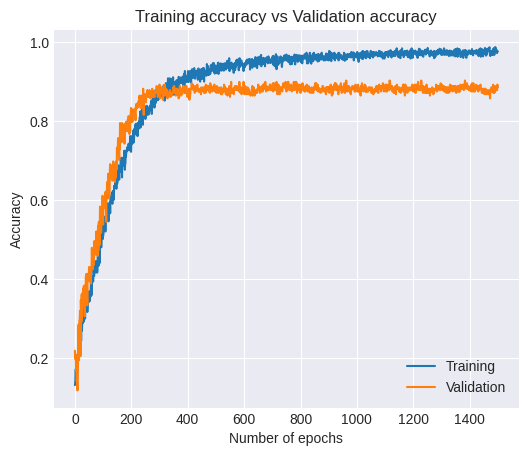

In [ ]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 100 
plt.figure(1,figsize=(6,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 100 
plt.figure(2,figsize=(6,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])       

9/9 [==============================] - 0s 10ms/step - loss: 0.9582 - accuracy: 0.8854
Loss of the model is -  0.9582136869430542
9/9 [==============================] - 0s 10ms/step - loss: 0.9582 - accuracy: 0.8854
Accuracy of the model is -  88.54166865348816 %


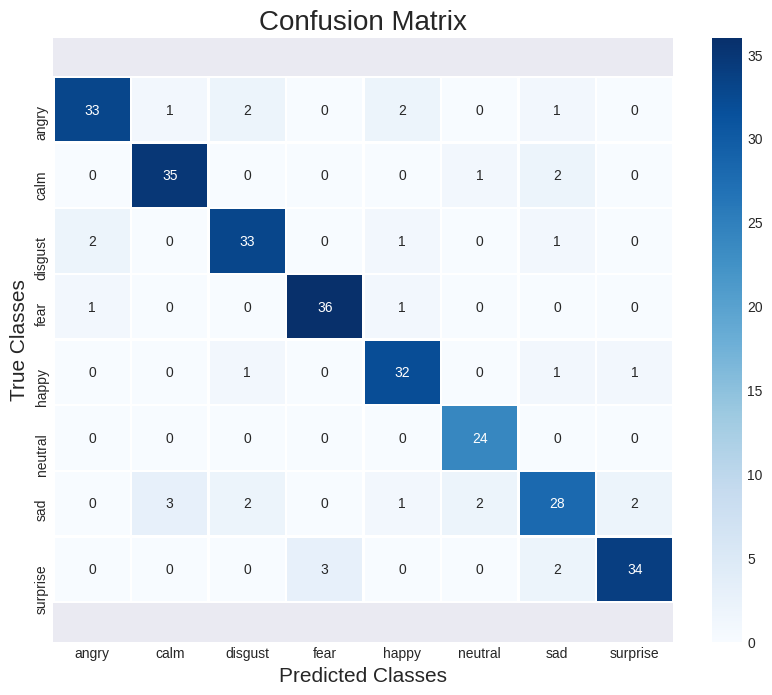

In [ ]:
# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[40:50] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (10, 8))
plt.rcParams['figure.dpi'] = 200 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('Initial_Model_Confusion_Matrix-SGD-CHROMA.png')
plt.show() 

In [ ]:
print(classification_report(TRUE, predictions, target_names = ['angry','calm','disgust','fear','happy','neutral','sad','surprise']))

              precision    recall  f1-score   support

       angry       0.92      0.85      0.88        39
        calm       0.90      0.92      0.91        38
     disgust       0.87      0.89      0.88        37
        fear       0.92      0.95      0.94        38
       happy       0.86      0.91      0.89        35
     neutral       0.89      1.00      0.94        24
         sad       0.80      0.74      0.77        38
    surprise       0.92      0.87      0.89        39

    accuracy                           0.89       288
   macro avg       0.88      0.89      0.89       288
weighted avg       0.89      0.89      0.88       288



In [ ]:
# PREDICTION LABELS
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'True Values': TRUE})

# COMBINE PREDICTION AND TRUE LABELS
finaldf = TRUE.join(predictions)
finaldf[100:150] 

True Values Predicted Values
100  disgust     disgust        
101  surprise    surprise       
102  fear        fear           
103  neutral     neutral        
104  sad         sad            
105  fear        fear           
106  angry       angry          
107  surprise    surprise       
108  disgust     disgust        
109  sad         sad            
110  disgust     disgust        
111  sad         neutral        
112  surprise    surprise       
113  fear        fear           
114  calm        calm           
115  neutral     neutral        
116  disgust     disgust        
117  fear        fear           
118  calm        calm           
119  fear        fear           
120  calm        calm           
121  calm        calm           
122  calm        calm           
123  happy       happy          
124  sad         sad            
125  disgust     angry          
126  neutral     neutral        
127  disgust     disgust        
128  calm        calm           
129  happy       happy          
130  happy       happy          
131  surprise    surprise       
132  happy       happy          
133  disgust     disgust        
134  sad         sad            
135  calm        calm           
136  disgust     disgust        
137  neutral     neutral        
138  sad         sad            
139  fear        fear           
140  sad         sad            
141  surprise    surprise       
142  neutral     neutral        
143  sad         disgust        
144  fear        fear           
145  sad         sad            
146  disgust     disgust        
147  angry       angry          
148  surprise    surprise       
149  angry       angry

In [ ]:
model = tf.keras.Sequential()
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(X_train.shape[1],1)))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(64, kernel_size=(5),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8, activation='softmax'))
model.summary()
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

checkpoint = ModelCheckpoint("SER_best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy',f1_m, precision_m, recall_m])
model_history=model.fit(X_Test, y_train,batch_size=32, epochs=1000, validation_data=(X_test, y_test),callbacks=[checkpoint])

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_366 (Conv1D)          (None, 259, 256)          2304      
_________________________________________________________________
conv1d_367 (Conv1D)          (None, 252, 256)          524544    
_________________________________________________________________
max_pooling1d_320 (MaxPoolin (None, 126, 256)          0         
_________________________________________________________________
batch_normalization_305 (Bat (None, 126, 256)          1024      
_________________________________________________________________
dropout_364 (Dropout)        (None, 126, 256)          0         
_________________________________________________________________
conv1d_368 (Conv1D)          (None, 126, 256)          524544    
_________________________________________________________________
max_pooling1d_321 (MaxPoolin (None, 63, 256)         

IndexError: ignored

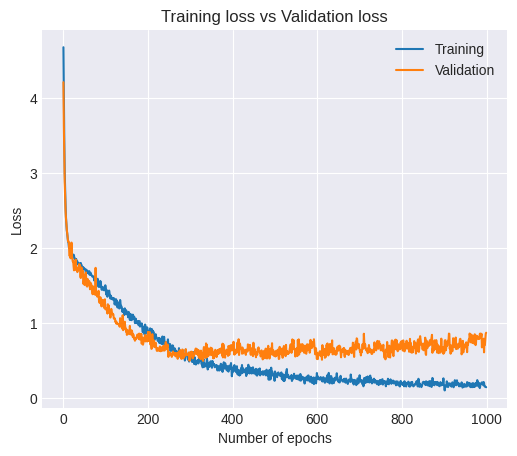

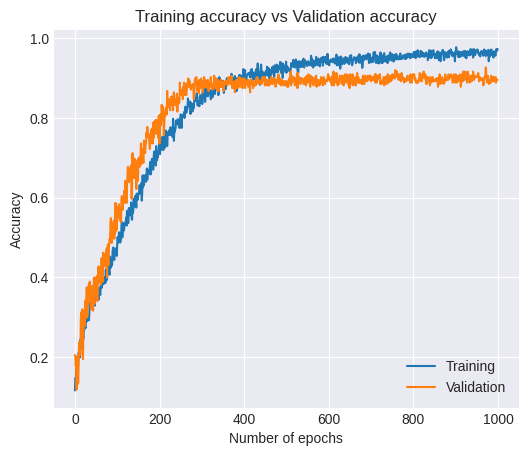

In [ ]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 100 
plt.figure(1,figsize=(6,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 100 
plt.figure(2,figsize=(6,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])       

In [ ]:
print(classification_report(TRUE, predictions, target_names = ['angry','calm','disgust','fear','happy','neutral','sad','surprise']))

              precision    recall  f1-score   support

       angry       0.92      0.85      0.88        39
        calm       0.90      0.92      0.91        38
     disgust       0.87      0.89      0.88        37
        fear       0.92      0.95      0.94        38
       happy       0.86      0.91      0.89        35
     neutral       0.89      1.00      0.94        24
         sad       0.80      0.74      0.77        38
    surprise       0.92      0.87      0.89        39

    accuracy                           0.89       288
   macro avg       0.88      0.89      0.89       288
weighted avg       0.89      0.89      0.88       288



In [ ]:
# PREDICTION LABELS
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'True Values': TRUE})

# COMBINE PREDICTION AND TRUE LABELS
finaldf = TRUE.join(predictions)
finaldf[100:150] 

True Values Predicted Values
100  disgust     disgust        
101  surprise    surprise       
102  fear        fear           
103  neutral     neutral        
104  sad         sad            
105  fear        fear           
106  angry       angry          
107  surprise    surprise       
108  disgust     disgust        
109  sad         sad            
110  disgust     disgust        
111  sad         neutral        
112  surprise    surprise       
113  fear        fear           
114  calm        calm           
115  neutral     neutral        
116  disgust     disgust        
117  fear        fear           
118  calm        calm           
119  fear        fear           
120  calm        calm           
121  calm        calm           
122  calm        calm           
123  happy       happy          
124  sad         sad            
125  disgust     angry          
126  neutral     neutral        
127  disgust     disgust        
128  calm        calm           
129  happy       neutral        
130  happy       happy          
131  surprise    surprise       
132  happy       happy          
133  disgust     disgust        
134  sad         sad            
135  calm        calm           
136  disgust     disgust        
137  neutral     neutral        
138  sad         sad            
139  fear        fear           
140  sad         sad            
141  surprise    surprise       
142  neutral     neutral        
143  sad         disgust        
144  fear        fear           
145  sad         sad            
146  disgust     disgust        
147  angry       angry          
148  surprise    surprise       
149  angry       angry

In [ ]:
# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[40:50] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9, 8))
plt.rcParams['figure.dpi'] = 200 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='crest_r', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('Initial_Model_Confusion_Matrix-SGD-CHROMA.png')
plt.show() 

ValueError: ignored